# CS109A FINAL PROJECT SUBMISSION - CORRADO MOSCONI, RAHUL GUDA, SIMRAN SHAH
## PROJECT #28 - SPOTIFY DATA

In [49]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from scipy import stats
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
import time
import datetime
import os
import pandas as pd
import sys
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
#!pip install imblearn
import imblearn
from imblearn.over_sampling import RandomOverSampler
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

In [50]:
#Initialize data objects to be used in the rest of the analysis
df = pd.read_csv("all_data").drop(columns=["Unnamed: 0", "target"])

# Replace True and False in explicit column with 1 and 0, respectively
df.loc[ df['explicit'] == True, "explicit"] = 1
df.loc[ df['explicit'] == False, "explicit"] = 0

X = df.drop(columns = "popularity")
y = df["popularity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, shuffle = True)

# Columns with numerical variables
num_col = ["danceability", 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'album_pos']
x_train_num = X_train[num_col]
x_test_num = X_test[num_col]

# Columns with binary variables
bin_col = ["mode","decade00","decade10","decade60",
           "decade70","decade80","decade90", "explicit"]

# Columns with categorical variables
cat_col = ["key","time_signature"]

### Basic data visualization and EDA

In [51]:
#columns
for i in df.columns:
    print(i)

danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
time_signature
chorus_hit
sections
decade00
decade10
decade60
decade70
decade80
decade90
popularity
album_pos
explicit


In [52]:
df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  duration_ms  time_signature  chorus_hit  sections  decade00  decade10  decade60  decade70  decade80  decade90  popularity  album_pos explicit
0         0.578   0.471    4    -7.270     1       0.0289      0.368000           0.00000     0.159    0.532  133.061       196707               4    30.88059        13       1.0       0.0       0.0       0.0       0.0       0.0          57          3        0
1         0.704   0.854   10    -5.477     0       0.1830      0.018500           0.00000     0.148    0.688   92.988       242587               4    41.51106        10       1.0       0.0       0.0       0.0       0.0       0.0          58          2        0
2         0.162   0.836    9    -3.009     1       0.0473      0.000111           0.00457     0.174    0.300   86.964       338893               4    65.32887        13       1.0       0.0       0.0       0.0       0.0       0.0           0          7        0
3         0.188   0.994    4    -3.745     1       0.1660      0.000007           0.07840     0.192    0.333  148.440       255667               4    58.59528         9       1.0       0.0       0.0       0.0       0.0       0.0           0          6        0
4         0.630   0.764    2    -4.353     1       0.0275      0.363000           0.00000     0.125    0.631  112.098       193760               4    22.62384        10       1.0       0.0       0.0       0.0       0.0       0.0          41          1        0

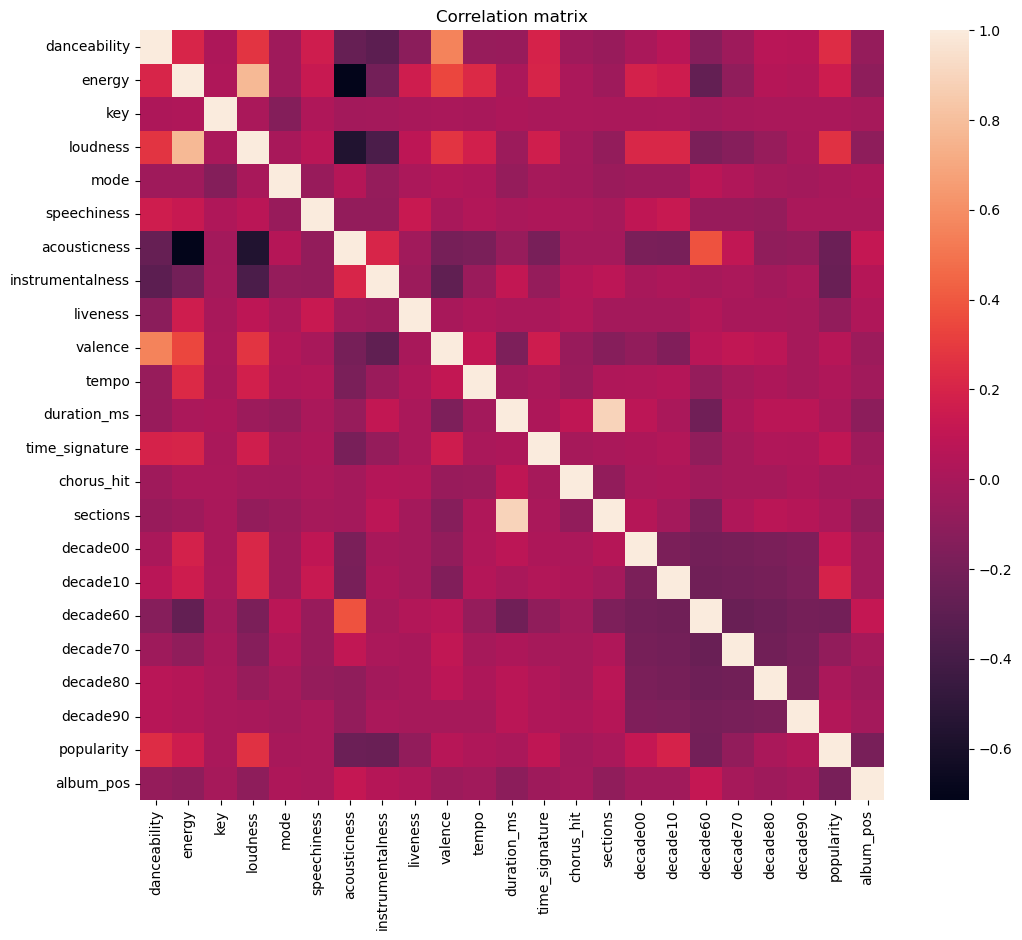

In [53]:
#correlation matrix
fig = plt.figure()
fig.set_size_inches(12,10)

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation matrix")
plt.show()

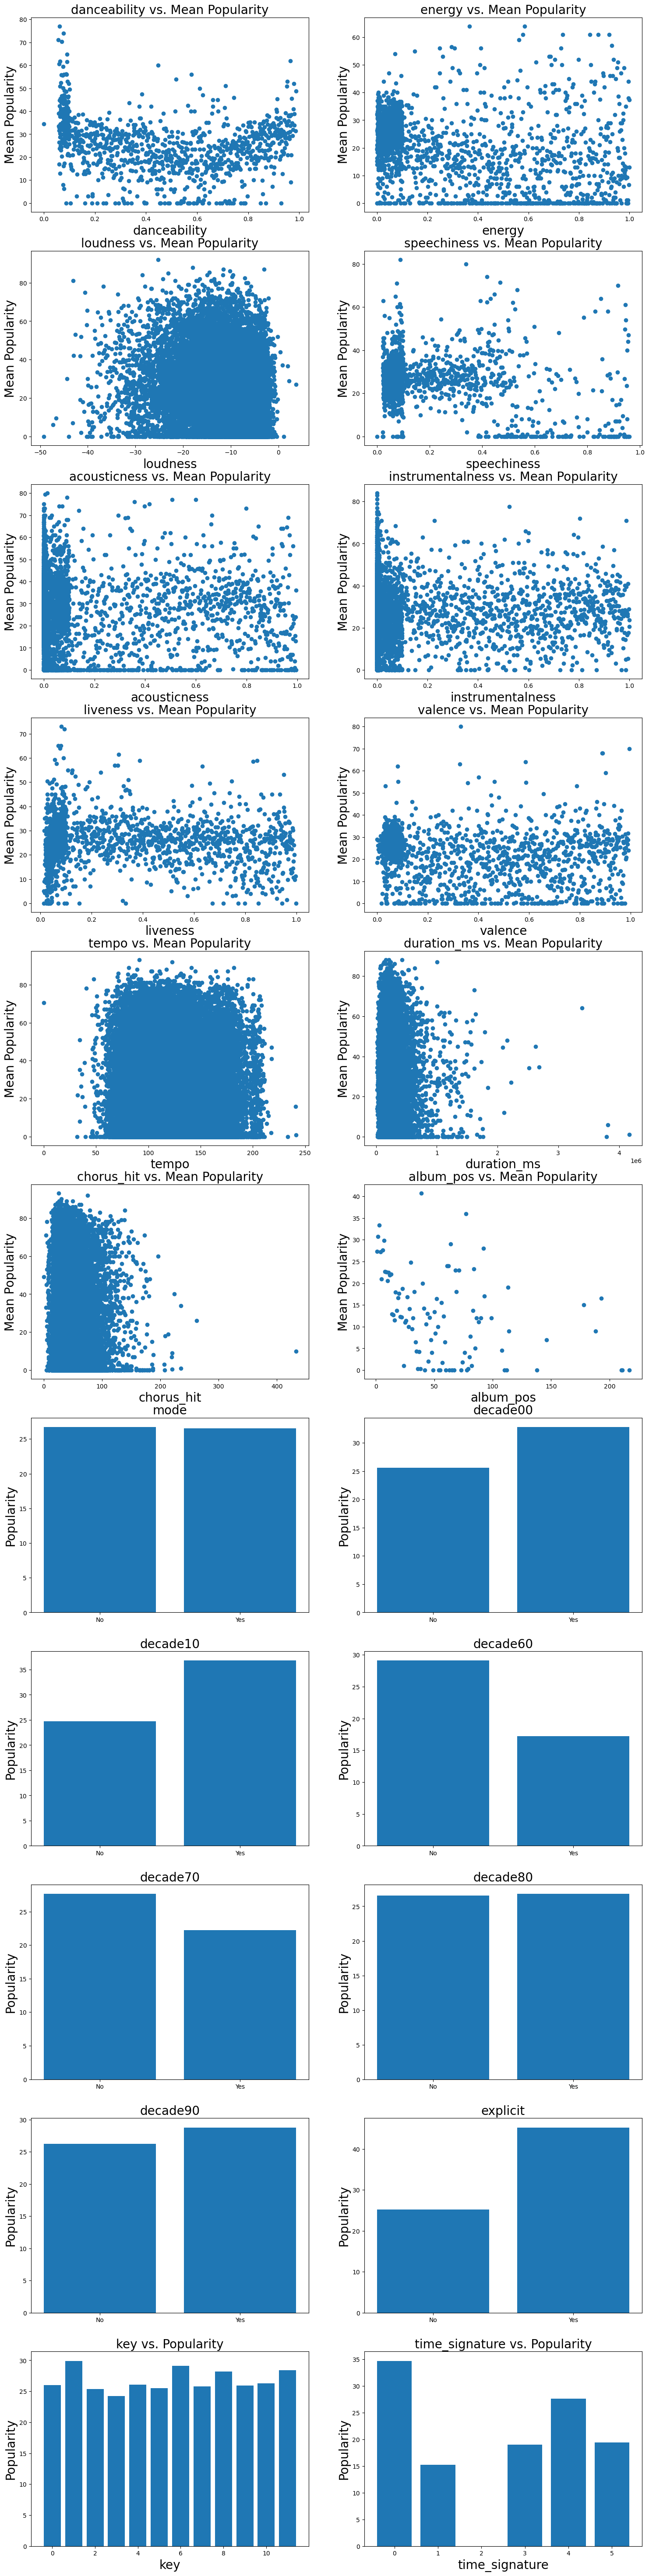

In [54]:
# Set up graphs
fig, axs = plt.subplots(nrows = 11, ncols = 2, figsize=(18, 75))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

# Plot all numerical variables as scatterplots
for col,i in zip(num_col,range(len(num_col))):
    mean_pop = df.groupby(col)['popularity'].mean()
    unique_val = df[col].unique()
    
    axs[i].set_title(f'{col} vs. Mean Popularity', fontsize = 20)
    axs[i].scatter(unique_val,mean_pop)
    axs[i].set_ylabel("Mean Popularity", fontsize=20)
    axs[i].set_xlabel(col, fontsize=20)
    
# Plot all binary variables as bar charts
for col,i in zip(bin_col,range(12,12+len(bin_col))):
    graph_df = pd.DataFrame(df.groupby(col)['popularity'].mean())
    
    axs[i].set_title(f'{col}', fontsize = 20)
    axs[i].bar(graph_df.index,graph_df['popularity'])
    axs[i].set_ylabel('Popularity',fontsize=20)
    axs[i].set_xticks([0,1],['No','Yes'])
    
# Plot all categorical variables as bar charts
for col,i in zip(cat_col,range(20,20+len(cat_col))):
    graph_df = pd.DataFrame(df.groupby(col)['popularity'].mean())
    
    axs[i].set_title(f'{col} vs. Popularity', fontsize = 20)
    axs[i].bar(graph_df.index,graph_df['popularity'])
    axs[i].set_ylabel('Popularity',fontsize=20)
    axs[i].set_xlabel(col, fontsize=20)

### Linear Regression

In [55]:
from sklearn.feature_selection import RFE

X = X_train
y = y_train

lr_num = LinearRegression()
lr_num.fit(x_train_num, y_train)
print('numerical train r^2 score:', lr_num.score(x_train_num, y_train))
print('numerical test r^2 score:', lr_num.score(x_test_num, y_test))

y_pred_num = lr_num.predict(x_test_num)
print('numerical data - mean absolute error on test data:', metrics.mean_absolute_error(y_test, y_pred_num))
print('numerical data - mean squared error on test data:', metrics.mean_squared_error(y_test, y_pred_num))

lr_tot = LinearRegression()
lr_tot.fit(X_train, y_train)
print('all data train r^2 score:', lr_tot.score(X_train, y_train))
print('all data test r^2 score:', lr_tot.score(X_test, y_test))
lreg_r2_test_val = lr_tot.score(X_test, y_test)

y_pred_tot = lr_tot.predict(X_test)
print('all data - mean absolute error on test data:', metrics.mean_absolute_error(y_test, y_pred_tot))
print('all data - mean squared error on test data:', metrics.mean_squared_error(y_test, y_pred_tot))
lreg_mse_test = metrics.mean_squared_error(y_test, y_pred_tot)

# Standardized Multivariate Linear Regression

X_train_norm = pd.DataFrame()

for col in X_train:
    X_train_norm[col] = (X_train[col] - X_train[col].mean())/(X_train[col].std())
    
X_test_norm = pd.DataFrame()

for col in X_test:
    X_test_norm[col] = (X_test[col] - X_test[col].mean())/(X_test[col].std())
    
lr_std = LinearRegression()
lr_std.fit(X_train_norm, y_train)
print('Normalized train r^2 score:', lr_std.score(X_train_norm, y_train))
print('Normalized test r^2 score:', lr_std.score(X_test_norm, y_test))

y_pred_norm = lr_std.predict(X_test_norm)
print('Normalized data - mean absolute error on test data:', metrics.mean_absolute_error(y_test, y_pred_norm))
print('Normalized data - mean squared error on test data:', metrics.mean_squared_error(y_test, y_pred_norm))

numerical train r^2 score: 0.18307501073613608
numerical test r^2 score: 0.17682444903979655
numerical data - mean absolute error on test data: 17.69589060690615
numerical data - mean squared error on test data: 440.65349790725844
all data train r^2 score: 0.22676866882129465
all data test r^2 score: 0.21450982655113016
all data - mean absolute error on test data: 17.076345495865915
all data - mean squared error on test data: 420.480166227334
Normalized train r^2 score: 0.22676866882129476
Normalized test r^2 score: 0.21461510789279015
Normalized data - mean absolute error on test data: 17.085016331034552
Normalized data - mean squared error on test data: 420.4238081498708


### Recrusive Feature Elimination (NORMALIZED DATA)

In [56]:
from sklearn.feature_selection import RFE

# Fit Linear Regression Model on Train Data
linreg = LinearRegression().fit(X_train_norm, y_train)

#Initializing RFE model
rfe = RFE(linreg)# random number(2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_norm,y_train)  

rfe_tf = np.array(rfe.support_)
print("True/False Importance of Predictors:",rfe_tf)

predictors = np.array(X_train_norm.columns)
imp_pred_rfe = []
for i in range(len(rfe_tf)):
    if rfe_tf[i] == True:
        imp_pred_rfe.append(predictors[i])

print("Important Components via RFE:",imp_pred_rfe)

True/False Importance of Predictors: [ True  True False  True False  True  True  True False False False False
 False False False False  True  True  True False False  True  True]
Important Components via RFE: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'decade10', 'decade60', 'decade70', 'album_pos', 'explicit']


In [57]:
linreg_rfe = LinearRegression().fit(X_train_norm[imp_pred_rfe], y_train)
y_pred_rfe = linreg_rfe.predict(X_test_norm[imp_pred_rfe])

print('numerical train r^2 score:', linreg_rfe.score(X_train_norm[imp_pred_rfe], y_train))
print('numerical test r^2 score:', linreg_rfe.score(X_test_norm[imp_pred_rfe], y_test))
rfe_test_r2 = linreg_rfe.score(X_test_norm[imp_pred_rfe], y_test)

print('all data - mean absolute error on test data:', metrics.mean_absolute_error(y_test, y_pred_rfe))
print('all data - mean squared error on test data:', metrics.mean_squared_error(y_test, y_pred_rfe))
rfe_test_mse = metrics.mean_squared_error(y_test, y_pred_rfe)

numerical train r^2 score: 0.21907693249728544
numerical test r^2 score: 0.2117625960206322
all data - mean absolute error on test data: 17.165358583303824
all data - mean squared error on test data: 421.95078417925134


### LASSO Regularization (NORMALIZED DATA)

In [58]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.linear_model import Lasso, LassoCV

X_train_std = pd.DataFrame()

for col in X_train.columns:
    if X_train[col].std() == 0:
        print(col)
    col_series = (X_train[col] - X_train[col].mean())/X_train[col].std()
    X_train_std[col] = col_series

alphas = [.1,.01, 1e-3, 1e-4, 1e-5]
alphas_str = []
for i in alphas:
    alphas_str.append(str(i))

models = LassoCV(alphas=alphas, max_iter = 1000)
models.fit(X_train_std, y_train)

lassoCV_val_mses_mean = models.mse_path_
best_alpha = models.alpha_
#print(lassoCV_val_mses_mean)
mean_alpha_mses = []

for i in lassoCV_val_mses_mean:
    mean_alpha_mses.append(np.mean(np.array(i)))
    
print("Best alpha:",best_alpha)


Best alpha: 0.01


Text(0.5, 1.0, 'Mean MSE for Each Alpha Value')

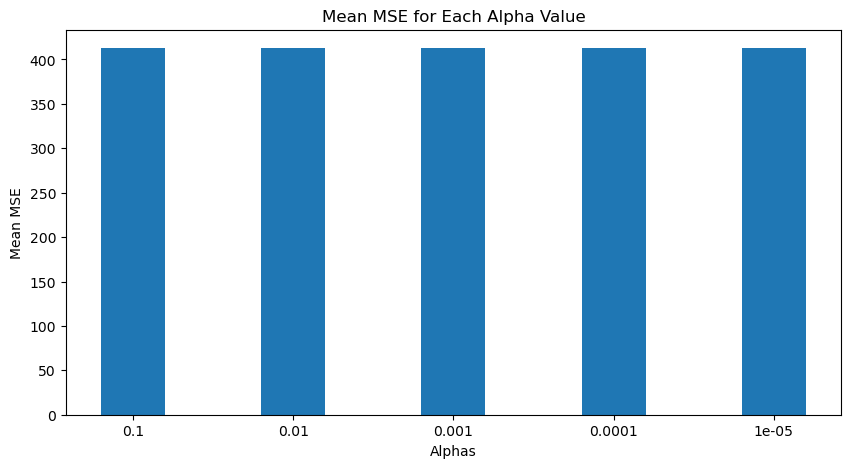

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(alphas_str,mean_alpha_mses, width = .4)
plt.xlabel("Alphas")
plt.ylabel("Mean MSE")
plt.title("Mean MSE for Each Alpha Value")

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade00', 'decade10', 'decade60', 'decade70', 'decade80', 'decade90', 'album_pos', 'explicit'], dtype='object')

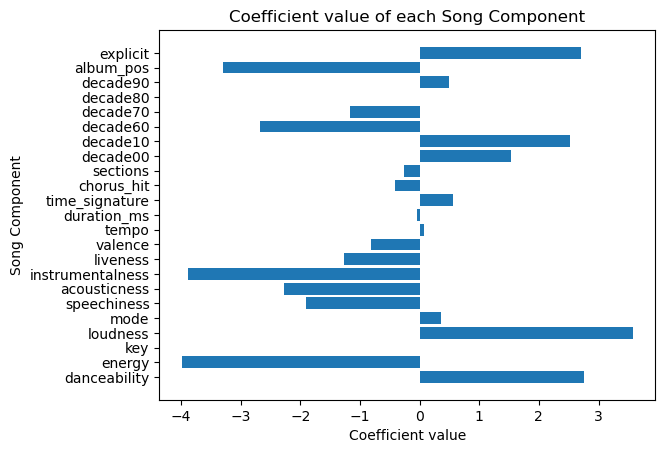

In [60]:
plt.barh(X_train_std.columns,models.coef_)
plt.xlabel("Coefficient value")
plt.ylabel("Song Component")
plt.title("Coefficient value of each Song Component")

X_train.columns

In [61]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
# Set bootstrapping parameters
numboot = 100

fit_intercept = True

# Create empty dictionary for storing results
significant_components = {}

print(X_train.columns)

df_train = X_train
df_train['popularity'] = y_train

for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    X_train_numcol_boot = df_boot[X_train.drop(['popularity'], axis = 1).columns]
    
    X_train_numcol_std_boot = pd.DataFrame()   
    
    for col in X_train.drop(['popularity'], axis = 1).columns:
        col_series = (X_train_numcol_boot[col] - X_train_numcol_boot[col].mean())/X_train_numcol_boot[col].std()
        X_train_numcol_std_boot[col] = col_series
    
    
    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=100000,
        alpha=best_alpha,
    )
    
    lasso.fit(X_train_numcol_std_boot, y_train)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_components.keys():
            significant_components[i]=1
        else:
            significant_components[i]+=1

del significant_components[0]

print(X_train.columns)

sig_comp_labels = {}
for key in significant_components.keys():
    sig_comp_labels[X_train.columns[key-1]] = significant_components[key]
    
print(sig_comp_labels)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade00', 'decade10', 'decade60', 'decade70', 'decade80', 'decade90', 'album_pos', 'explicit'], dtype='object')
Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade00', 'decade10', 'decade60', 'decade70', 'decade80', 'decade90', 'album_pos', 'explicit', 'popularity'], dtype='object')
{'danceability': 45, 'loudness': 51, 'speechiness': 41, 'acousticness': 51, 'instrumentalness': 46, 'valence': 47, 'duration_ms': 53, 'time_signature': 36, 'chorus_hit': 42, 'decade10': 35, 'decade60': 30, 'decade80': 28, 'decade90': 32, 'key': 49, 'sections': 51, 'decade00': 42, 'album_pos': 41, 'explicit': 36, 'energy': 57, 'liveness': 43, 'tempo': 4

[(1, 45), (2, 57), (3, 49), (4, 51), (5, 35), (6, 41), (7, 51), (8, 46), (9, 43), (10, 47), (11, 43), (12, 53), (13, 36), (14, 42), (15, 51), (16, 42), (17, 35), (18, 30), (19, 25), (20, 28), (21, 32), (22, 41), (23, 36)]


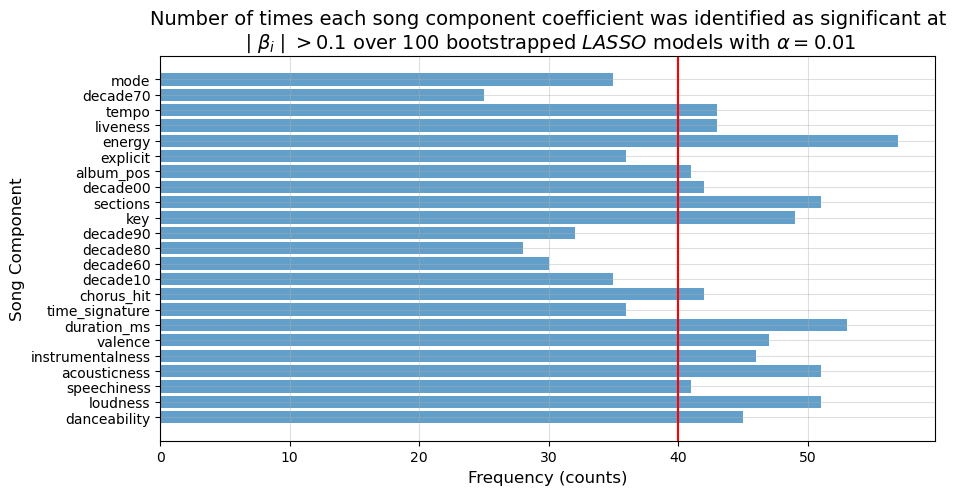

In [62]:
fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_components.items())
print(lists)

y = []
for i in range(len(lists)):
    y.append(lists[i][1])

numcol_lasso_dict = {}
for i in range(len(num_col)):
    numcol_lasso_dict[num_col[i]] = y[i]



ax.barh(list(sig_comp_labels.keys()), sig_comp_labels.values(), alpha=0.7)
ax.set_xlabel("Frequency (counts)", fontsize=12)
ax.set_ylabel("Song Component", fontsize=12)
ax.set_title(
    "Number of times each song component coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

ax.axvline(40, color = 'red')

In [63]:
# Choose predictors that are significant more than 40 times

numcol_dict_40 = []
for i in sig_comp_labels:
    if sig_comp_labels[i] > 40:
        numcol_dict_40.append(i)
        
        
# Working with only 4 predictors for new multi regression        
print(sig_comp_labels)
print(len(numcol_dict_40))

{'danceability': 45, 'loudness': 51, 'speechiness': 41, 'acousticness': 51, 'instrumentalness': 46, 'valence': 47, 'duration_ms': 53, 'time_signature': 36, 'chorus_hit': 42, 'decade10': 35, 'decade60': 30, 'decade80': 28, 'decade90': 32, 'key': 49, 'sections': 51, 'decade00': 42, 'album_pos': 41, 'explicit': 36, 'energy': 57, 'liveness': 43, 'tempo': 43, 'decade70': 25, 'mode': 35}
15


In [64]:
# Fit Linear Regression Model on Train Data
linreg = LinearRegression().fit(X_train[numcol_dict_40], y_train)

#Fitting the data to model
linreg.fit(X_train[numcol_dict_40],y_train)

# Generate training prediction and MSE
y_train_pred = linreg.predict(X_train[numcol_dict_40])
train_MSE = mean_squared_error(y_train,y_train_pred)

print("Train MSE:",train_MSE)

# Generate testing prediction and MSE
y_test_pred = linreg.predict(X_test[numcol_dict_40],)
test_MSE = mean_squared_error(y_test,y_test_pred)

print("Test MSE:",test_MSE)
lasso_test_mse = test_MSE

#Compute the R-squared of the model
lin_test_r2 = linreg.score(X_test[numcol_dict_40],y_test)
lasso_test_r2 = lin_test_r2
print("R^2 test:", lin_test_r2)

Train MSE: 433.8521733870949
Test MSE: 439.93760641915657
R^2 test: 0.17816179090351636


### KNN Classification

In [65]:
data = df.copy()
data['popularity'] = pd.cut(data['popularity'], bins = 3, labels = ['low','medium','high'])

In [66]:
X = data.drop(['popularity'], axis = 1)
y = data[['popularity']]
y.value_counts()

popularity
low           24437
medium        13234
high           3435
dtype: int64

In [67]:
ros = RandomOverSampler()

X_ros, y_ros = ros.fit_resample(X, y)

# print(X_ros.value_counts())
# print(y_ros.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state = 1, train_size=0.8)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_class))

Ks = np.arange(1,22)
param_dist = dict(n_neighbors = Ks)

rand = RandomizedSearchCV(knn, param_dist, cv = 5, scoring = 'accuracy', n_iter = 5, random_state = 1)

rand.fit(X_train,y_train)
print("Accuracy:",np.mean(rand.cv_results_['mean_test_score']))

knn_accuracy = np.mean(rand.cv_results_['mean_test_score'])

/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.8027006751687922


/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  

Accuracy: 0.5471728344801836


/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## POLYNOMIAL REGRESSION - Finding best degree models for each variable

In [71]:
#Initialize data objects to be used in the rest of the analysis
df = pd.read_csv("all_data").drop(columns=["Unnamed: 0", "target"])

# Replace True and False in explicit column with 1 and 0, respectively
df.loc[ df['explicit'] == True, "explicit"] = 1
df.loc[ df['explicit'] == False, "explicit"] = 0

X = df.drop(columns = "popularity")
y = df["popularity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, shuffle = True)

# Columns with numerical variables
num_col = ["danceability", 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'chorus_hit', 'album_pos']
x_train_num = X_train[num_col]
x_test_num = X_test[num_col]

# Columns with binary variables
bin_col = ["mode","decade00","decade10","decade60",
           "decade70","decade80","decade90", "explicit"]

# Columns with categorical variables
cat_col = ["key","time_signature"]

In [72]:
X = df.drop(columns = "popularity")
y = df["popularity"]

predictor: danceability


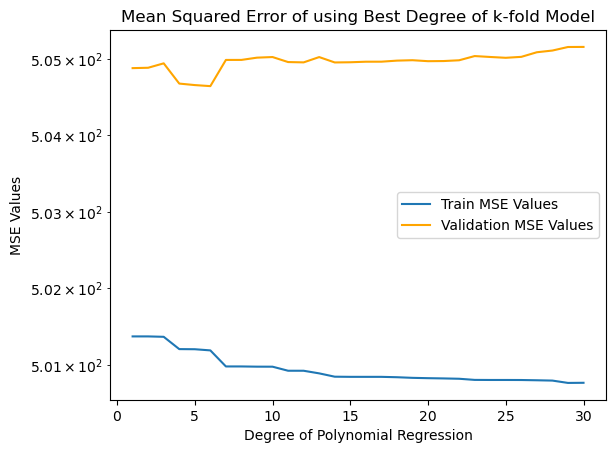

The best degree is 6


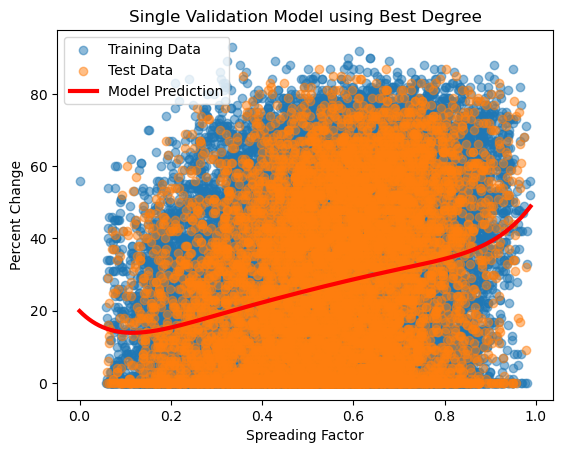

Best Train MSE: 500.76819299842236
Best Validation MSE: 504.64157262034865
predictor: energy


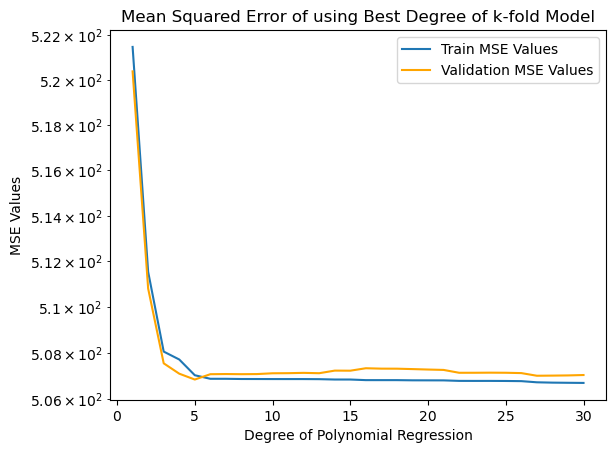

The best degree is 5


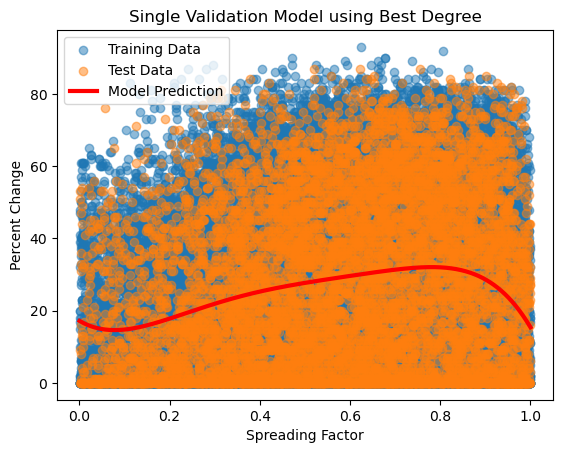

Best Train MSE: 506.7051637156359
Best Validation MSE: 506.85192163493457
predictor: loudness


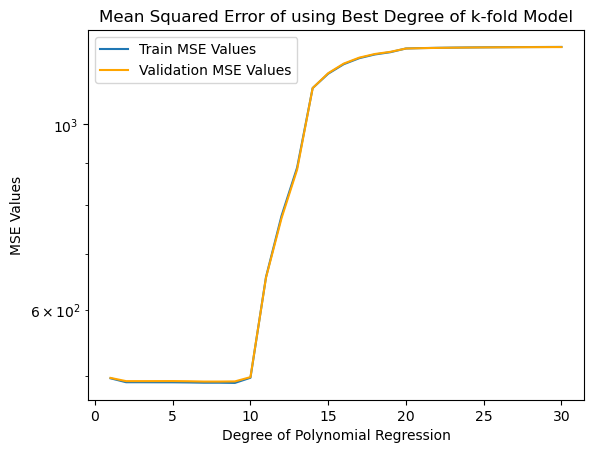

The best degree is 8


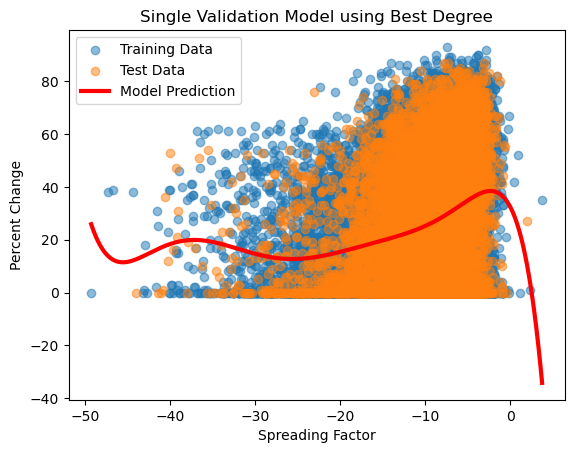

Best Train MSE: 490.3764938098126
Best Validation MSE: 492.2244072036487
predictor: speechiness


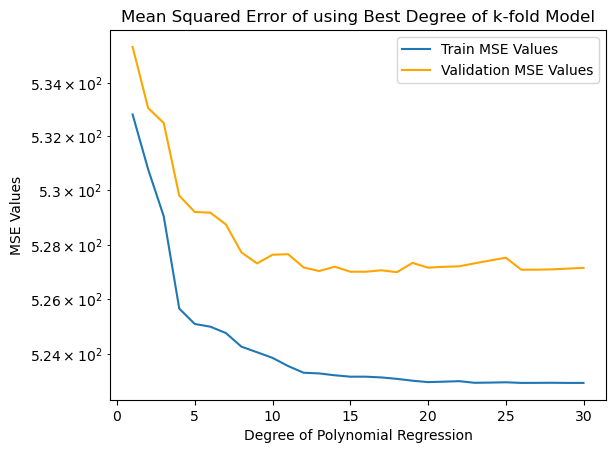

The best degree is 18


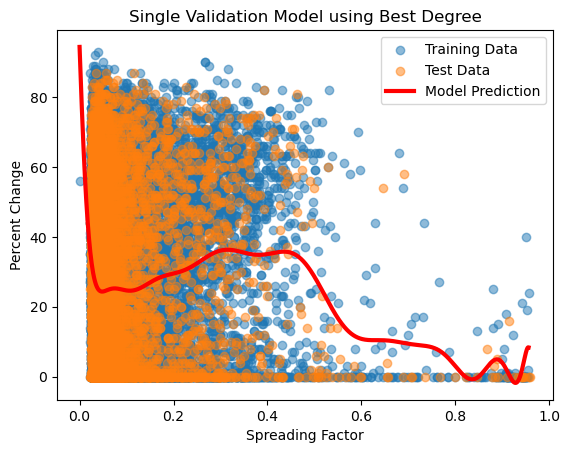

Best Train MSE: 522.9327561054853
Best Validation MSE: 526.9871719598497
predictor: acousticness


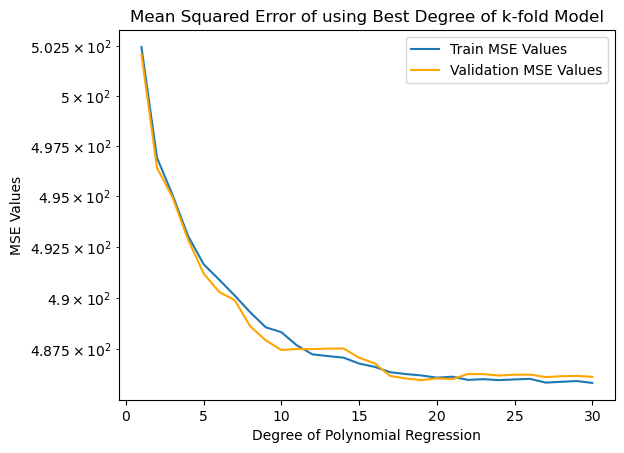

The best degree is 19


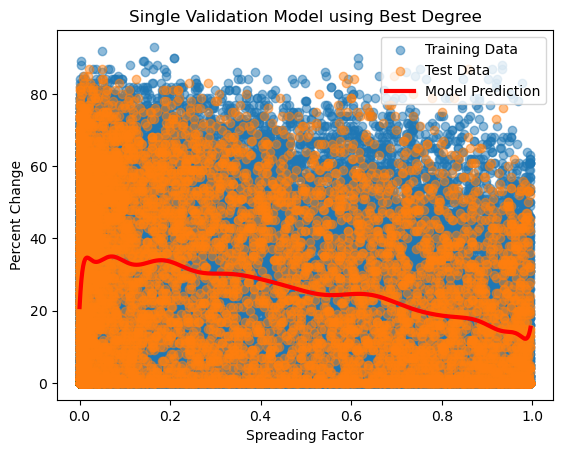

Best Train MSE: 485.87281897300255
Best Validation MSE: 486.00852896506893
predictor: instrumentalness


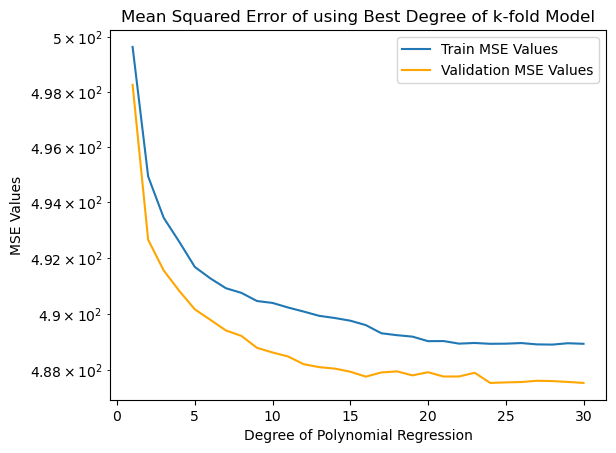

The best degree is 30


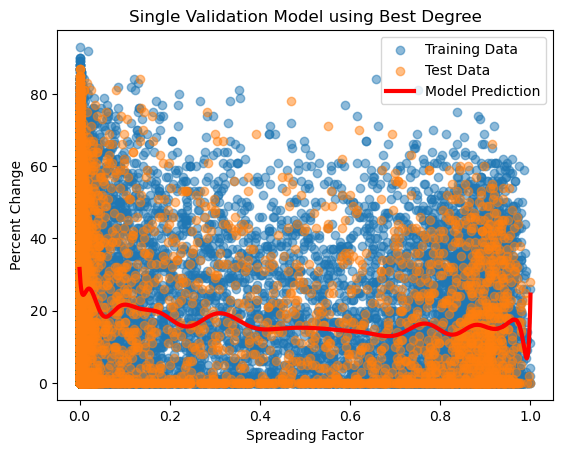

Best Train MSE: 488.90003463807903
Best Validation MSE: 487.5349092042837
predictor: liveness


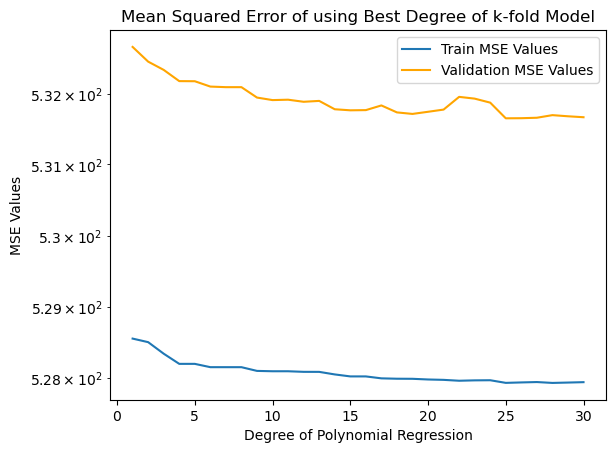

The best degree is 25


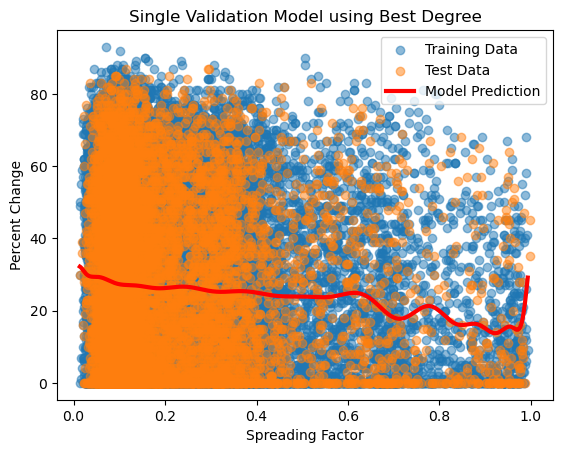

Best Train MSE: 527.9305776551379
Best Validation MSE: 531.6513948906381
predictor: valence


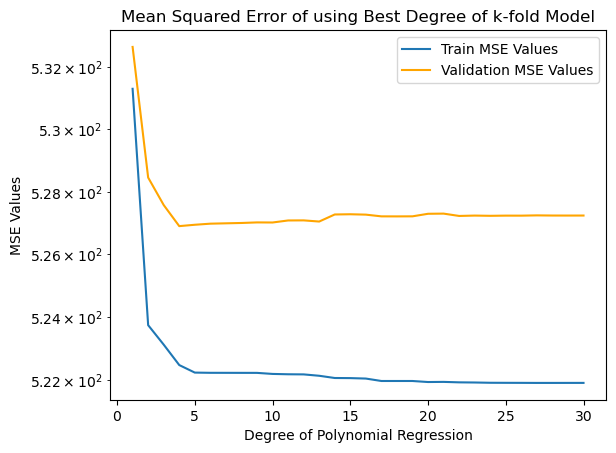

The best degree is 4


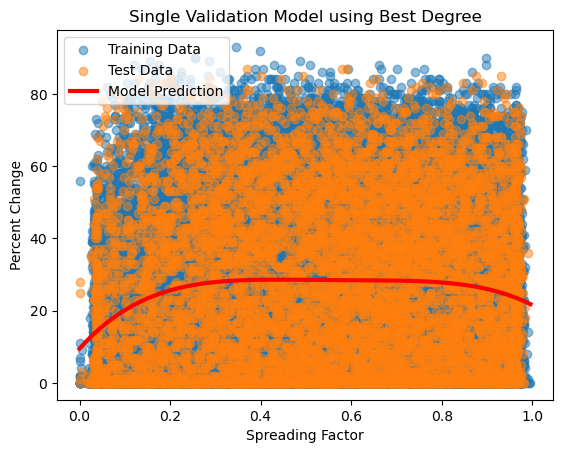

Best Train MSE: 521.9111652700418
Best Validation MSE: 526.8966407939436
predictor: tempo


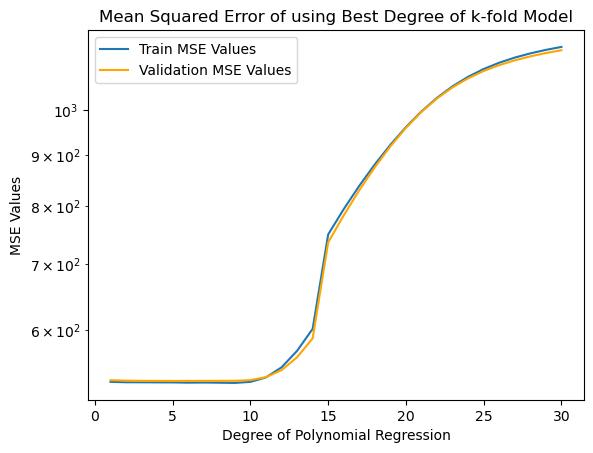

The best degree is 5


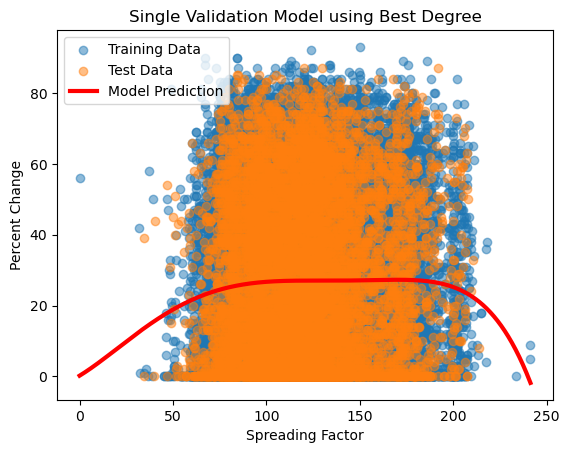

Best Train MSE: 531.2649980575706
Best Validation MSE: 533.6467413432362
predictor: duration_ms


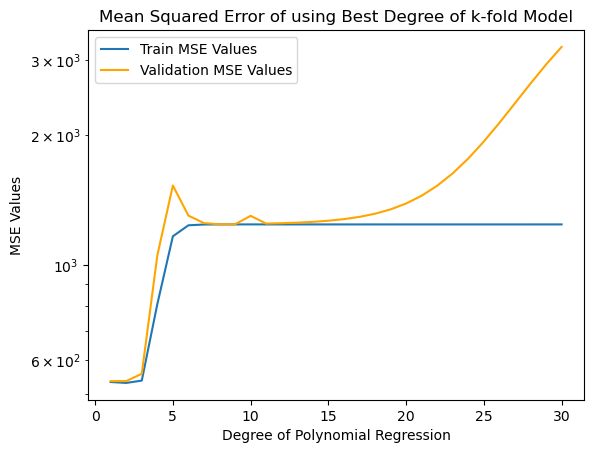

The best degree is 1


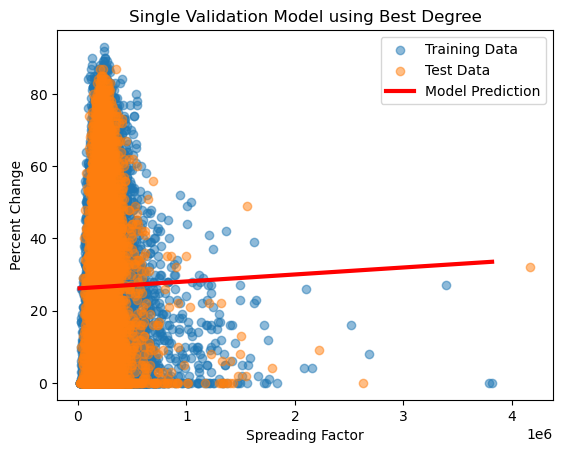

Best Train MSE: 530.2191521716223
Best Validation MSE: 535.3618380487119
predictor: chorus_hit


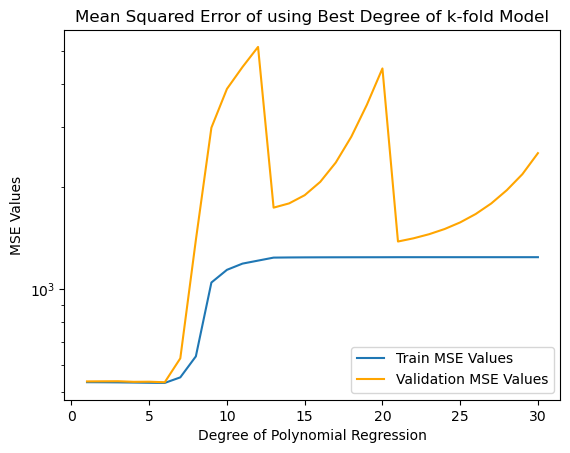

The best degree is 6


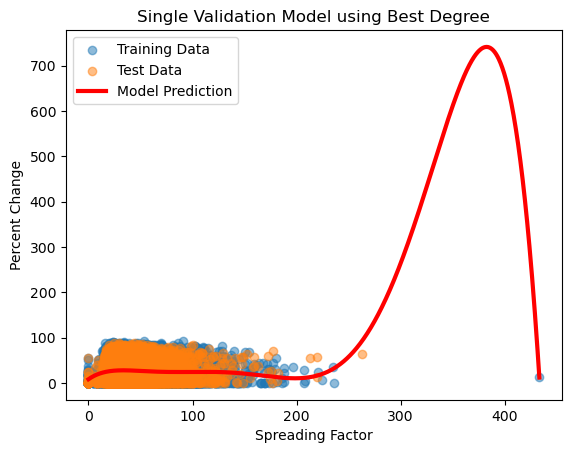

Best Train MSE: 529.9097896384754
Best Validation MSE: 532.3261983001397
predictor: album_pos


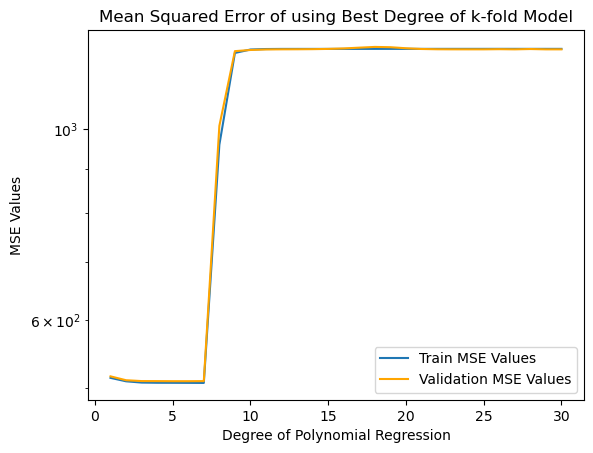

The best degree is 6


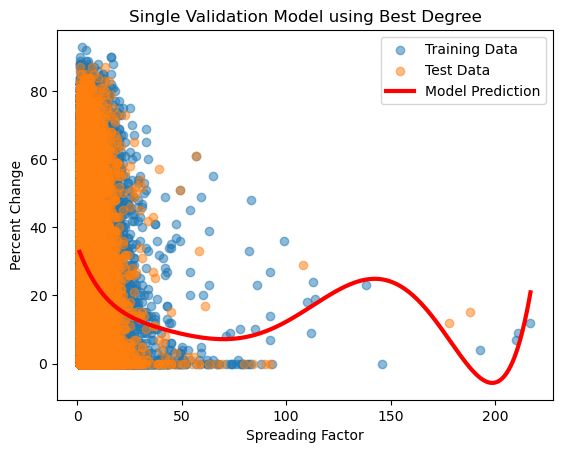

Best Train MSE: 506.5213695091149
Best Validation MSE: 508.8585400463743


In [73]:
for i in num_col:

    x_data_train = X_train[[i]]
    x_data_test = X_test[[i]]

    train_mses = []
    val_mses = []
    maxdeg = 30

    for d in range(maxdeg):
        # Compute the polynomial features for the current degree 
        # for the train set
        x_poly_train = PolynomialFeatures(degree = d+1).fit_transform(x_data_train)

        # Compute the polynomial features for the validation set
        x_poly_val = PolynomialFeatures(degree = d+1).fit_transform(x_data_test)

        # Initialize a linear regression model with fit_intercept as False
        lreg = LinearRegression(fit_intercept=False)

        # Fit the model on the train data
        lreg.fit(x_poly_train, y_train)

        # Use the trained model to predict on the transformed train data
        y_train_pred = lreg.predict(x_poly_train)

        # Use the trained model to predict on the transformed validation data
        y_val_pred = lreg.predict(x_poly_val)

        # Compute the MSE on the train predictions
        train_mses.append(mean_squared_error(y_train, y_train_pred))

        # Compute the MSE on the validation predictions
        val_mses.append(mean_squared_error(y_test, y_val_pred))

    print(f'predictor: {i}')
    ks = np.linspace(1, 30, 30)
    plt.plot(ks, train_mses, label = 'Train MSE Values')
    plt.errorbar(ks, val_mses,  c = 'orange', label = 'Validation MSE Values')

    plt.legend()
    plt.yscale("log")
    plt.xlabel("Degree of Polynomial Regression")
    plt.ylabel("MSE Values")
    plt.title('Mean Squared Error of using Best Degree of k-fold Model')
    min_mse_val = min(val_mses)
    best_degree_new = val_mses.index(min_mse_val) + 1
    plt.show()
    print('The best degree is', best_degree_new)
    
    plt.scatter(x_data_train, y_train, label = 'Training Data', alpha = 0.5)
    plt.scatter(x_data_test, y_test, label = 'Test Data', alpha = 0.5)
    
    #Train
    xvals = np.linspace(x_data_train.min(), x_data_train.max(), 1000)
    xvals = pd.DataFrame(xvals, columns=[i])


    x_total_train = PolynomialFeatures(degree = best_degree_new, include_bias=False).fit_transform(x_data_train)
    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(x_total_train, y_train)

    y_train_pred = linreg.predict(x_total_train)
    train_mse_new = mean_squared_error(y_train, y_train_pred)
    
    #Test 
    x_total_test = PolynomialFeatures(degree = best_degree_new, include_bias=False).fit_transform(x_data_test)

    y_test_pred = linreg.predict(x_total_test)
    test_mse_new = mean_squared_error(y_test, y_test_pred)

    x_model = PolynomialFeatures(degree = best_degree_new, include_bias=False).fit_transform(xvals)
    y_pred = linreg.predict(x_model)
    
    #BIN THE SCATTERPLOTS
    
    plt.plot(xvals, y_pred, label = 'Model Prediction', color = 'red', linewidth=3)
    plt.legend()
    plt.ylabel('Percent Change')
    plt.xlabel('Spreading Factor')
    plt.title('Single Validation Model using Best Degree')
    plt.show()

    print('Best Train MSE:', min(train_mses))
    print('Best Validation MSE:', min(val_mses))

### Binary Logistic Regression

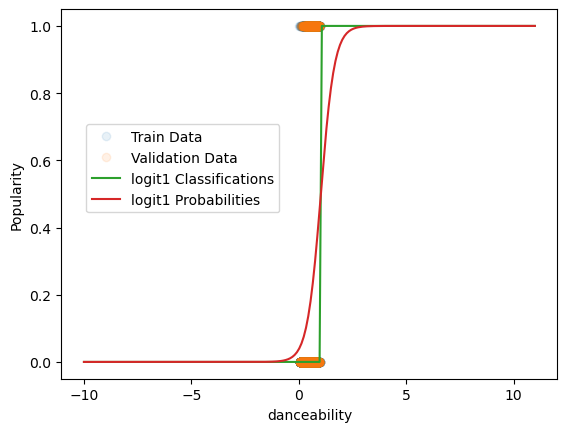

PREDICTOR:, danceability
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


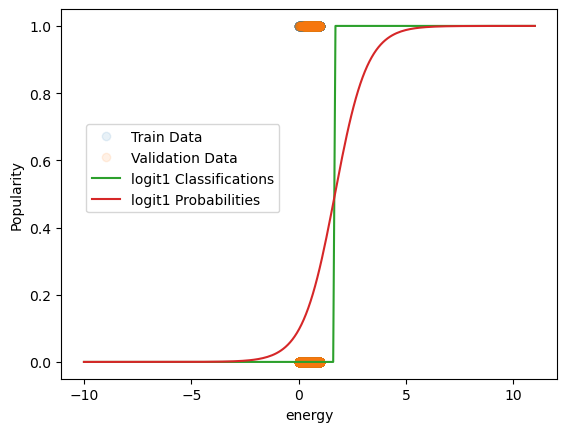

PREDICTOR:, energy
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


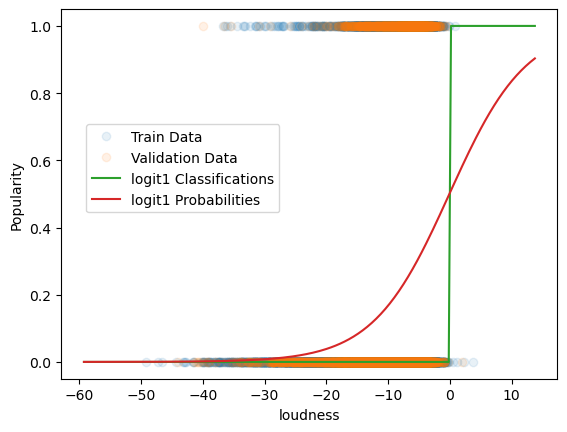

PREDICTOR:, loudness
Train Accuracy 0.8090864858289746
Validation Accuracy 0.8024811481391388


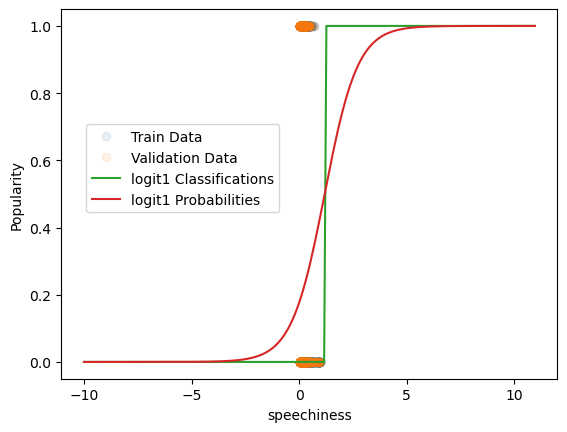

PREDICTOR:, speechiness
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


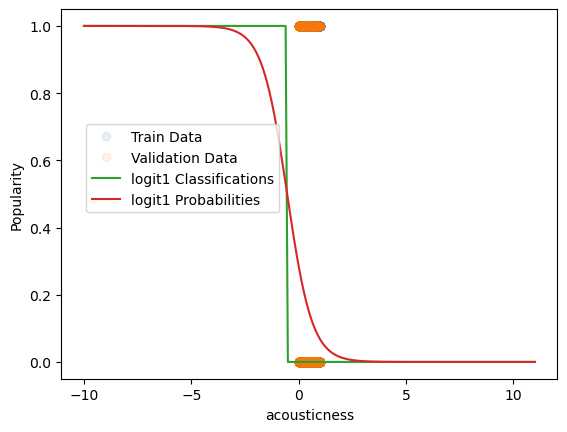

PREDICTOR:, acousticness
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


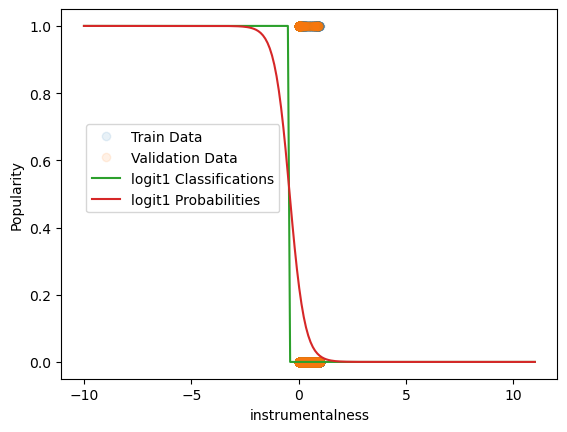

PREDICTOR:, instrumentalness
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


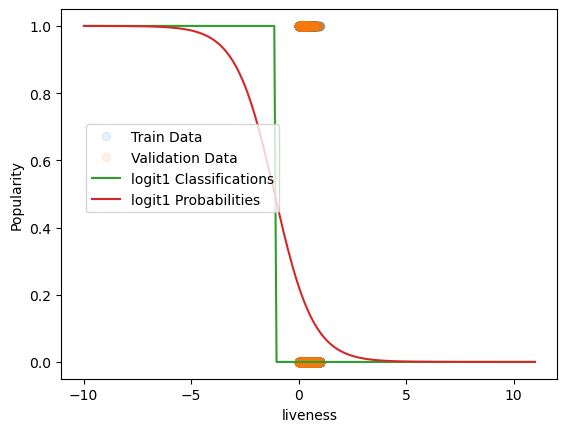

PREDICTOR:, liveness
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


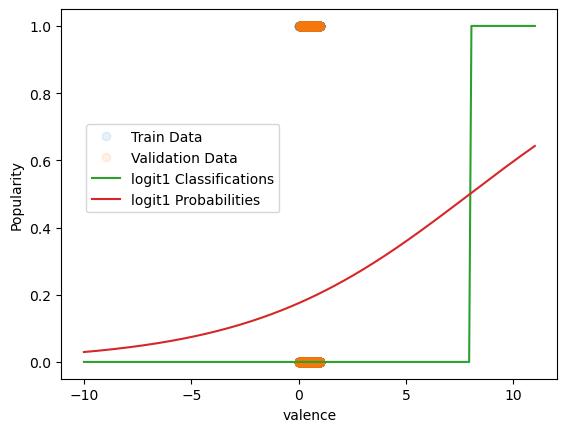

PREDICTOR:, valence
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


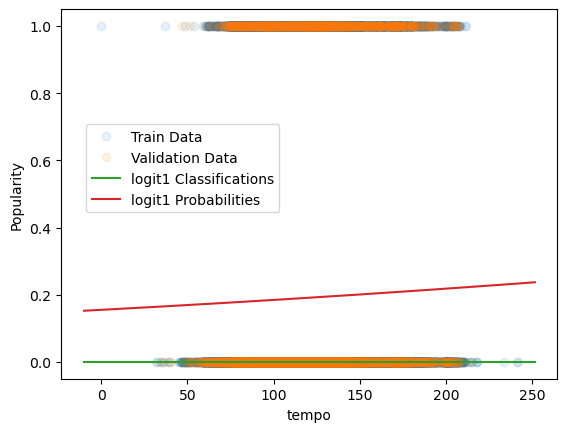

PREDICTOR:, tempo
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


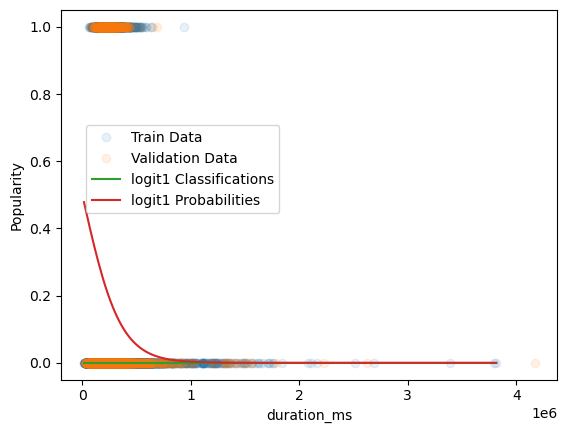

PREDICTOR:, duration_ms
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


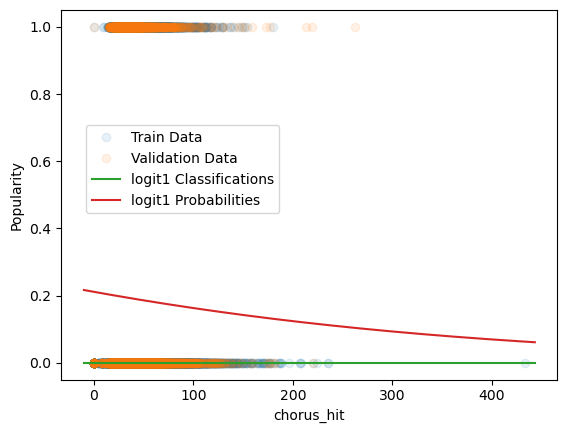

PREDICTOR:, chorus_hit
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


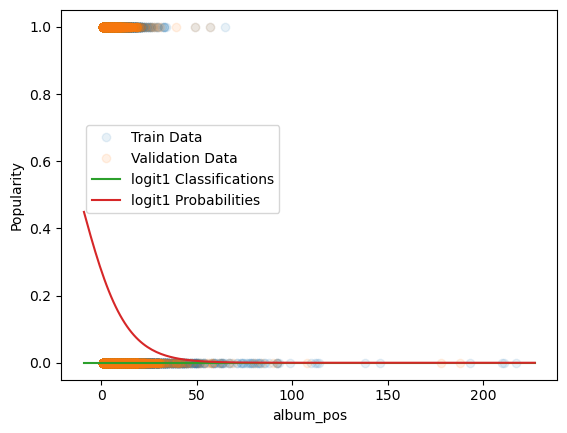

PREDICTOR:, album_pos
Train Accuracy 0.809177715606374
Validation Accuracy 0.8026027730479202


In [74]:
train_bins = pd.DataFrame()
test_bins = pd.DataFrame()
train_bins['y_values'] = y_train
test_bins['y_values'] = y_test

train_bins['y_values'].loc[(train_bins['y_values'] >= 0) & (train_bins['y_values'] <= 50)] = 0
train_bins['y_values'].loc[(train_bins['y_values'] > 50) & (train_bins['y_values'] <= 100)] = 1

test_bins['y_values'].loc[(test_bins['y_values'] >= 0) & (test_bins['y_values'] <= 50)] = 0
test_bins['y_values'].loc[(test_bins['y_values'] > 50) & (test_bins['y_values'] <= 100)] = 1


for i in X_train[num_col].columns:
    
    logit = LogisticRegression(penalty='none', max_iter = 1000, random_state=5)

    #Fit the model using the training set

    logit.fit(X_train[[i]].values, train_bins['y_values'].values)

    train_accuracy = logit.score(X_train[[i]].values, train_bins['y_values'].values)
    val_accuracy = logit.score(X_test[[i]].values, test_bins['y_values'].values)

    # Print the two accuracies below



    x = np.linspace(X_train[[i]].min() - 10, X_train[[i]].max() + 10, 200)

    yhat_class_logit = logit.predict(x)
    yhat_prob_logit = logit.predict_proba(x)[:,1]

    # plot the observed data
    plt.plot(X_train[[i]], train_bins['y_values'], 'o' ,alpha=0.1, label='Train Data')
    plt.plot(X_test[[i]], test_bins['y_values'], 'o' ,alpha=0.1, label='Validation Data')

    # plot the predictions
    plt.plot(x, yhat_class_logit, label='logit1 Classifications')
    plt.plot(x, yhat_prob_logit, label='logit1 Probabilities')

    # put the lower-left part of the legend 5% to the right along the x-axis, and 45% up along the y-axis
    plt.legend(loc=(0.05,0.45))

    # Don't forget your axis labels
    plt.xlabel(i)
    plt.ylabel('Popularity')

    plt.show()
    print(f'PREDICTOR:, {i}')
    print("Train Accuracy", train_accuracy)
    print("Validation Accuracy", val_accuracy)

### Decision tree regressor

In [75]:
X = df.drop(columns = "popularity")
y = df["popularity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, shuffle = True)

In [76]:
#underfit (depth = 2) decision tree classifier
dt2 = DecisionTreeRegressor(max_depth = 2)
dt2.fit(X_train,y_train)

#overfit (depth = 10) decision tree classifier
dt10 = tree.DecisionTreeRegressor(max_depth = 10)
dt10.fit(X_train,y_train);

In [77]:
print(mean_squared_error(y_train, dt2.predict(X_train)))
print(mean_squared_error(y_test, dt2.predict(X_test)))
decision_tree_test_mse_dt10 = mean_squared_error(y_test, dt10.predict(X_test))
decision_tree_test_mse_dt2 = mean_squared_error(y_test, dt2.predict(X_test))

465.98285961540637
472.11788239862005


In [78]:
# Evaluate using r2
print("R^2 score on train for dt2:",dt2.score(X_train, y_train))
print("R^2 score on test for dt2:",dt2.score(X_test, y_test))
print("R^2 score on train for dt10:",dt10.score(X_train, y_train))
print("R^2 score on test for dt10:",dt10.score(X_test, y_test))
dec_tree_r2_dt2 = dt2.score(X_test, y_test)
dec_tree_r2_dt10 = dt10.score(X_test, y_test)

R^2 score on train for dt2: 0.12548636825378645
R^2 score on test for dt2: 0.11804649274917955
R^2 score on train for dt10: 0.3790336117921751
R^2 score on test for dt10: 0.1822362271453668


In [79]:
#finding the best depth for decision tree regressor
depths = [i for i in range(1,21)]
train_scores = []
cvmeans = []
cvstds = []
for d in depths:
    dt = DecisionTreeRegressor(max_depth = d).fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))

    model = DecisionTreeRegressor(max_depth = d)
    scores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())
best_depth_cv = depths[cvmeans.index(max(cvmeans))]

/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[  0.384   0.465   0.417 ...   0.631   0.558   0.551]
 [  0.283   0.744   0.496 ...   0.755   0.818   0.572]
 [-15.493  -8.74   -4.546 ...  -7.206  -4.07   -7.244]
 ...
 [  1.      0.      1.    ...   0.      0.      0.   ]
 [  0.      1.      0.    ...   0.      0.      1.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]] loaded from the file /var/folders/pk/52vffg353lg6y09h2141lxm40000gn/T/joblib_memmapping_folder_51747_5b0d065b620b45b6bb0b87fcd2c0555d_ffac7c9dcdaa4df8881bc8f8b7abb38c/51747-5991475824-b73e1484e93a4e7cb9a1f39440b76a2e.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for 

In [80]:
print("best depth: ", best_depth_cv,"  and respective r2 score: ", train_scores[best_depth_cv-1])
best_depth_cv_regressor = best_depth_cv
best_r2_dec_tree = train_scores[best_depth_cv-1]

best depth:  7   and respective r2 score:  0.2838571224999896


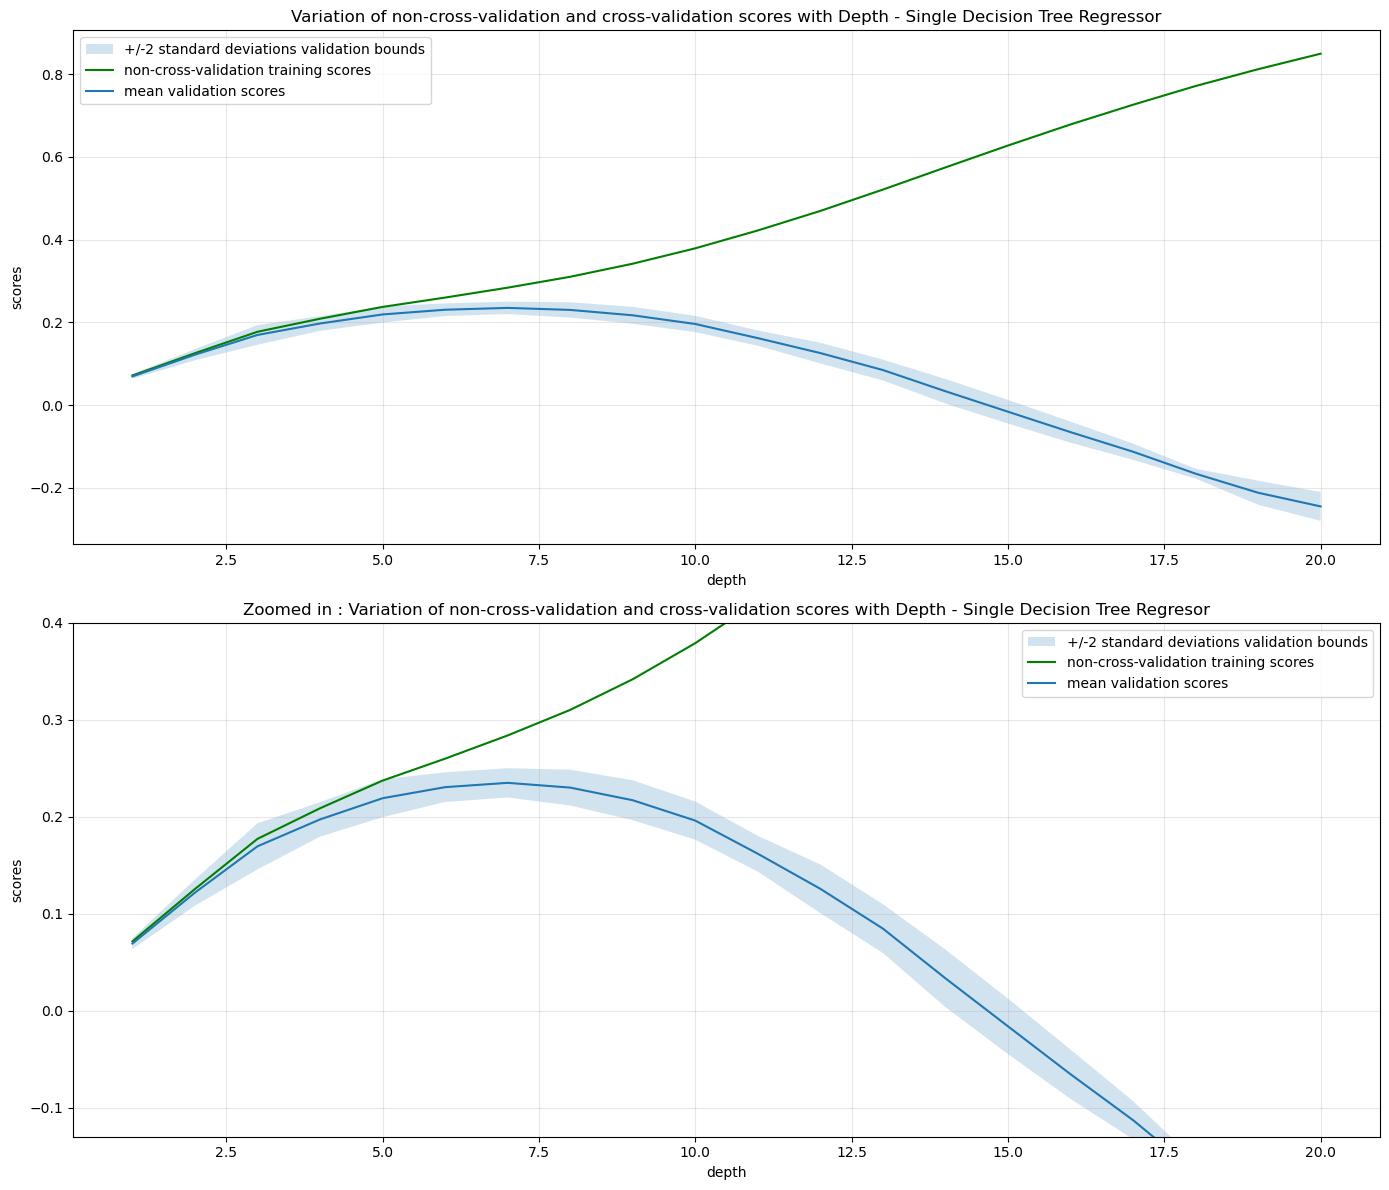

In [81]:
#Variation of non-cross-validation and cross-validation scores with Depth - Single Decision Tree
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].fill_between(depths, [i+2*j for i,j in zip(cvmeans, cvstds)],
                     [i-2*j for i,j in zip(cvmeans, cvstds)], alpha=0.2, label = "+/-2 standard deviations validation bounds")
axes[0].plot(depths, train_scores, color = "green",label = "non-cross-validation training scores")
axes[0].plot(depths, cvmeans, label = "mean validation scores")
axes[0].set_ylabel("scores")
axes[0].set_xlabel("depth")
axes[0].set_title('Variation of non-cross-validation and cross-validation scores with Depth - Single Decision Tree Regressor')
axes[0].legend()
axes[0].grid(alpha = 0.3)

axes[1].fill_between(depths, [i+2*j for i,j in zip(cvmeans, cvstds)],
                     [i-2*j for i,j in zip(cvmeans, cvstds)], alpha=0.2, label = "+/-2 standard deviations validation bounds")
axes[1].plot(depths, train_scores, color = "green",label = "non-cross-validation training scores")
axes[1].plot(depths, cvmeans, label = "mean validation scores")
axes[1].set_ylabel("scores")
axes[1].set_xlabel("depth")
axes[1].set_title('Zoomed in : Variation of non-cross-validation and cross-validation scores with Depth - Single Decision Tree Regresor')
axes[1].legend()
axes[1].grid(alpha = 0.3)
axes[1].set_ylim([-0.13,0.4])


plt.tight_layout()
plt.show()

### Decision tree classifier

In [82]:
#transforming popularity in a categorical variable with 3 bins corresponding to 0_to_0.33, 0.33_to_0.66, 0.66_to_1 quantiles
buckets = [9,37,100]
y_train_buckets = []
y_test_buckets = []
for i in range(len(buckets)):
    y_train_buckets.append((y_train < buckets[i]).astype(int))
    y_test_buckets.append((y_test < buckets[i]).astype(int))
y_train_cat = sum(y_train_buckets)
y_test_cat = sum(y_test_buckets)

In [83]:
#underfit (depth = 2) decision tree classifier
dt2 = DecisionTreeClassifier(max_depth = 2)
dt2.fit(X_train,y_train_cat)

#overfit (depth = 10) decision tree classifier
dt10 = tree.DecisionTreeClassifier(max_depth = 10)
dt10.fit(X_train,y_train_cat)

DecisionTreeClassifier(max_depth=10)

In [84]:
# Evaluate using Accuracy
print("accuracy score on train for dt2:",dt2.score(X_train, y_train_cat))
print("accuracy score on test for dt2:",dt2.score(X_test, y_test_cat))
print("accuracy score on train for dt10:",dt10.score(X_train, y_train_cat))
print("accuracy score on test for dt10:",dt10.score(X_test, y_test_cat))
dt2_test_acc = dt2.score(X_test, y_test_cat)
dt10_test_acc = dt10.score(X_test, y_test_cat)

accuracy score on train for dt2: 0.43239873494708675
accuracy score on test for dt2: 0.4387010459742155
accuracy score on train for dt10: 0.5855127113489843
accuracy score on test for dt10: 0.5093651179761615


In [85]:
#finding the best depth for decision tree classifier
depths = [i for i in range(1,21)]
train_scores = []
cvmeans = []
cvstds = []
for d in depths:
    dt = DecisionTreeClassifier(max_depth = d).fit(X_train, y_train_cat)
    train_scores.append(dt.score(X_train, y_train_cat))

    model = DecisionTreeClassifier(max_depth = d)
    scores = cross_val_score(estimator = model, X = X_train, y = y_train_cat, cv = 5, n_jobs = -1)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())
best_depth_cv = depths[cvmeans.index(max(cvmeans))]

/Users/simran/Documents/Harvard_College/Senior_Fall_2022/CS109A/=~/micromamba/envs/cs109a/lib/python3.10/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[  0.384   0.465   0.417 ...   0.631   0.558   0.551]
 [  0.283   0.744   0.496 ...   0.755   0.818   0.572]
 [-15.493  -8.74   -4.546 ...  -7.206  -4.07   -7.244]
 ...
 [  1.      0.      1.    ...   0.      0.      0.   ]
 [  0.      1.      0.    ...   0.      0.      1.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]] loaded from the file /var/folders/pk/52vffg353lg6y09h2141lxm40000gn/T/joblib_memmapping_folder_51747_5b0d065b620b45b6bb0b87fcd2c0555d_110ced2241bf432f991e94d120156902/51747-5991475824-b73e1484e93a4e7cb9a1f39440b76a2e.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for 

In [86]:
print("best depth and respective accuracy score: ", best_depth_cv," ", train_scores[best_depth_cv-1])
best_depth_cv_classifier = best_depth_cv
dt_classifier_test_acc = train_scores[best_depth_cv-1]

best depth and respective accuracy score:  6   0.5224121153144387


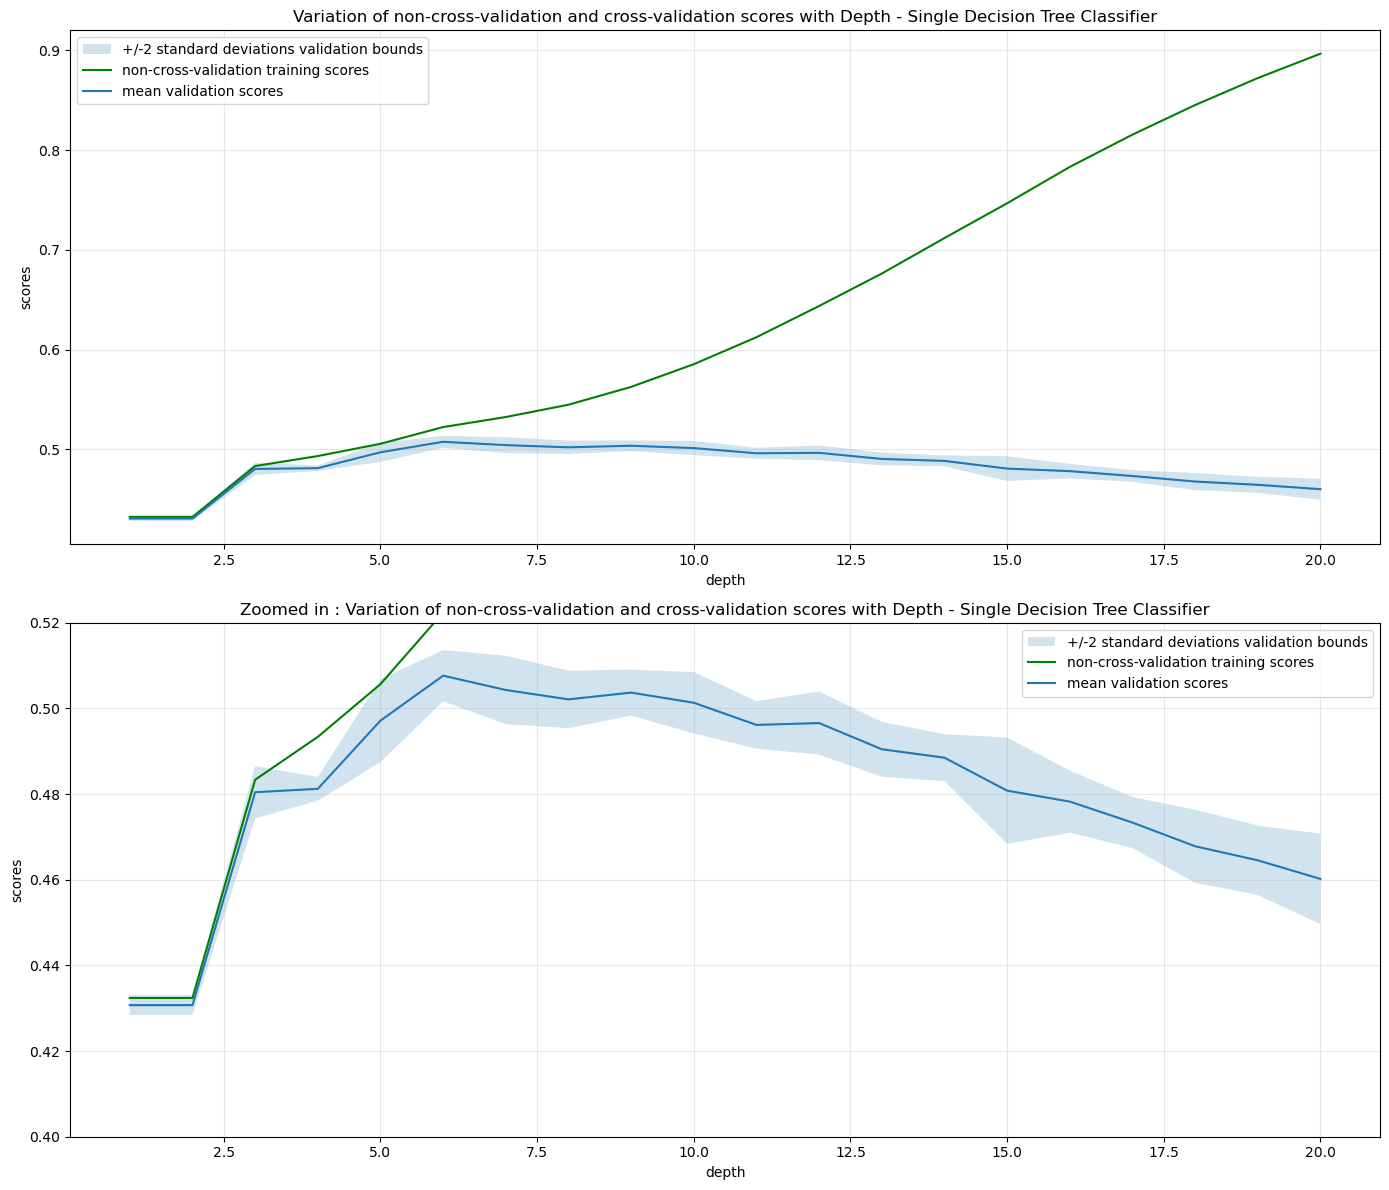

In [87]:
#Variation of non-cross-validation and cross-validation scores with Depth - Single Decision Tree
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].fill_between(depths, [i+2*j for i,j in zip(cvmeans, cvstds)],
                     [i-2*j for i,j in zip(cvmeans, cvstds)], alpha=0.2, label = "+/-2 standard deviations validation bounds")
axes[0].plot(depths, train_scores, color = "green",label = "non-cross-validation training scores")
axes[0].plot(depths, cvmeans, label = "mean validation scores")
axes[0].set_ylabel("scores")
axes[0].set_xlabel("depth")
axes[0].set_title('Variation of non-cross-validation and cross-validation scores with Depth - Single Decision Tree Classifier')
axes[0].legend()
axes[0].grid(alpha = 0.3)

axes[1].fill_between(depths, [i+2*j for i,j in zip(cvmeans, cvstds)],
                     [i-2*j for i,j in zip(cvmeans, cvstds)], alpha=0.2, label = "+/-2 standard deviations validation bounds")
axes[1].plot(depths, train_scores, color = "green",label = "non-cross-validation training scores")
axes[1].plot(depths, cvmeans, label = "mean validation scores")
axes[1].set_ylabel("scores")
axes[1].set_xlabel("depth")
axes[1].set_title('Zoomed in : Variation of non-cross-validation and cross-validation scores with Depth - Single Decision Tree Classifier')
axes[1].legend()
axes[1].grid(alpha = 0.3)
axes[1].set_ylim([0.4,0.52])


plt.tight_layout()
plt.show()

### Random forest regressor

In [88]:
tree_depth = 26
n_trees = 200
randomforest = RandomForestRegressor(n_estimators=n_trees, max_features='sqrt', max_depth=tree_depth).fit(X_train, y_train)
random_forest_train_score = randomforest.score(X_train, y_train)
random_forest_test_score = randomforest.score(X_test, y_test)
random_forest_regressor_test = random_forest_test_score

In [89]:
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following R^2 scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)



The random forest of depth-26 and 200 trees achieves the following R^2 scores:

	train	0.8908
	TEST	0.3149


### Random forest Classifier

In [90]:
tree_depth = 26
n_trees = 200
randomforest = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', max_depth=tree_depth).fit(X_train, y_train_cat)
random_forest_train_score = randomforest.score(X_train, y_train_cat)
random_forest_test_score = randomforest.score(X_test, y_test_cat)
random_forest_classifier_test = random_forest_test_score

In [91]:
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-26 and 200 trees achieves the following accuracy scores:

	train	0.9981
	TEST	0.5569


## ADA BOOST CLASSIFIER   
###### Version with 5 delimited bins

depth: 1 max validation value: 0.5102164923376308 n_estimators val: 746
depth: 2 max validation value: 0.5132571150571638 n_estimators val: 675
depth: 3 max validation value: 0.5178788615908538 n_estimators val: 678
depth: 4 max validation value: 0.5182437363171978 n_estimators val: 182
depth: 5 max validation value: 0.5177572366820725 n_estimators val: 77
depth: 6 max validation value: 0.5131354901483823 n_estimators val: 19


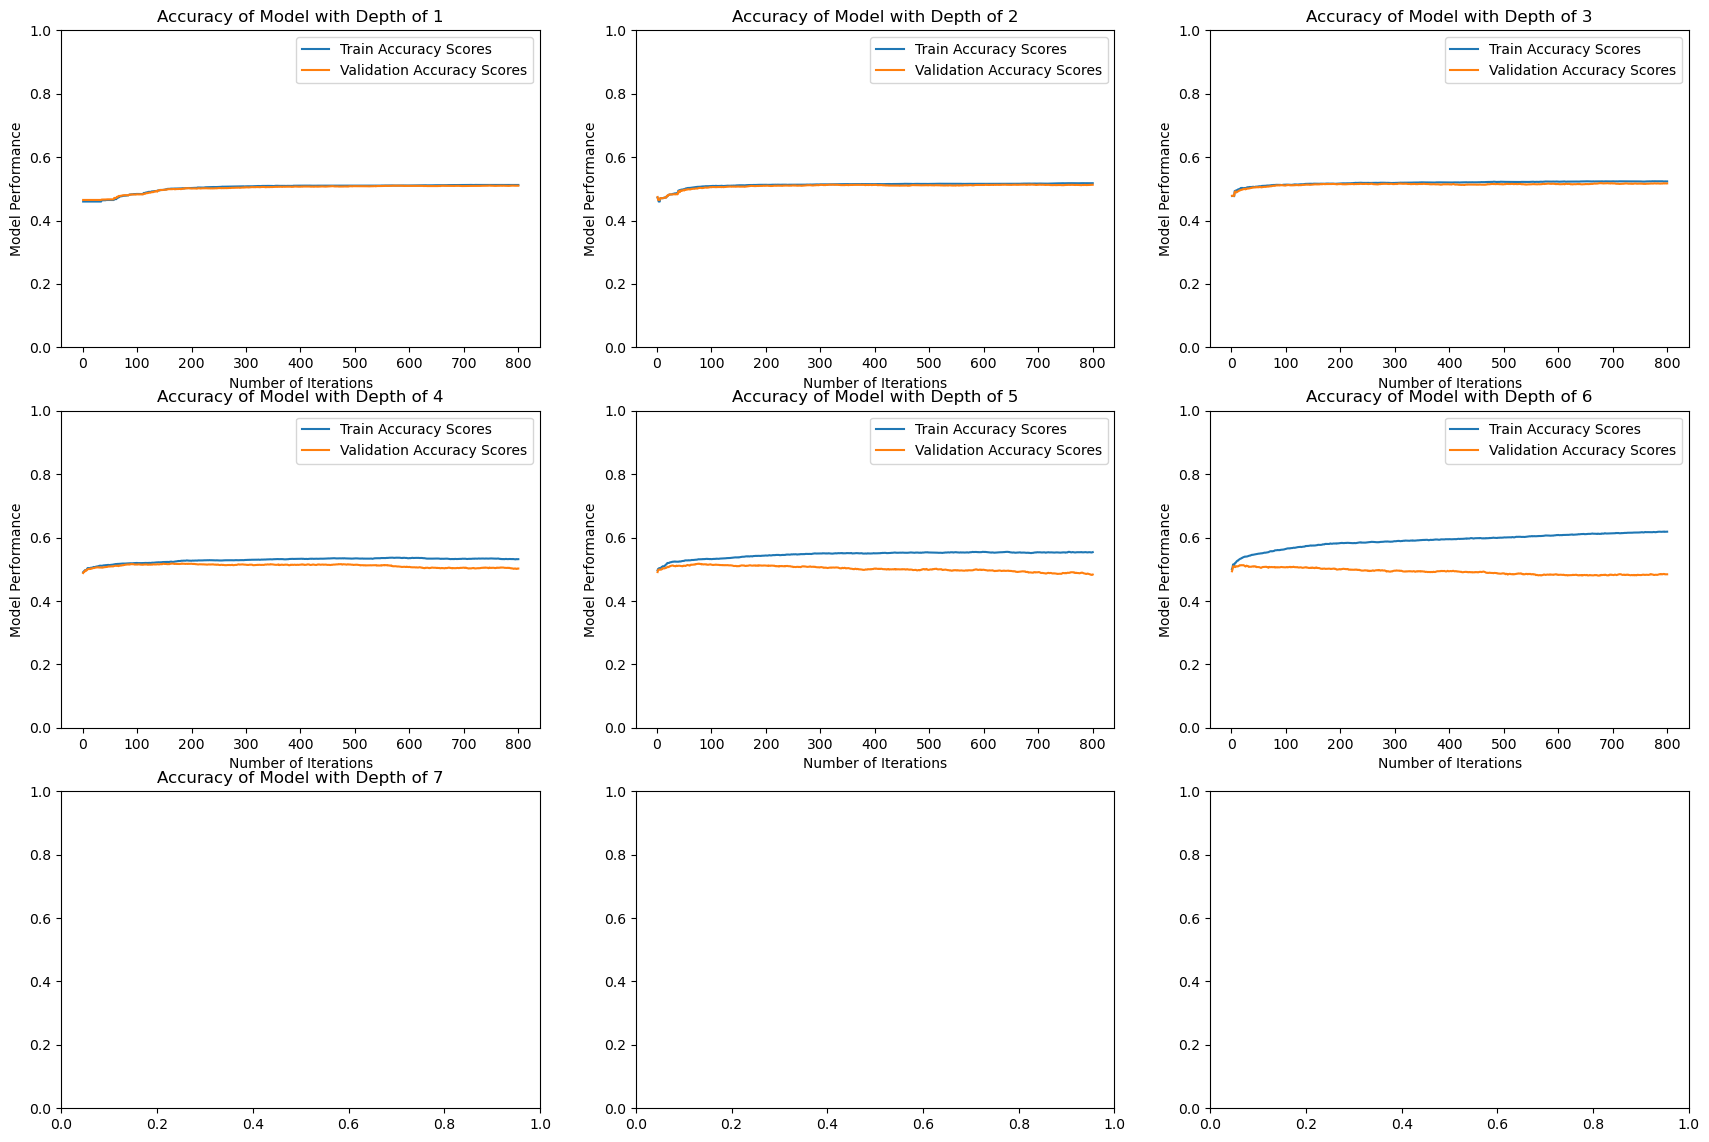

In [106]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (21, 14))
axes = axes.ravel()
iterations = np.linspace(1, 800, 800)

train_bins = pd.DataFrame()
test_bins = pd.DataFrame()
train_bins['y_values'] = y_train
test_bins['y_values'] = y_test

train_bins['y_values'].loc[(train_bins['y_values'] >= 0) & (train_bins['y_values'] < 20)] = 0
train_bins['y_values'].loc[(train_bins['y_values'] >= 20) & (train_bins['y_values'] < 40)] = 1
train_bins['y_values'].loc[(train_bins['y_values'] >= 40) & (train_bins['y_values'] < 60)] = 2
train_bins['y_values'].loc[(train_bins['y_values'] >= 60) & (train_bins['y_values'] < 80)] = 3
train_bins['y_values'].loc[(train_bins['y_values'] >= 80) & (train_bins['y_values'] < 100)] = 4

test_bins['y_values'].loc[(test_bins['y_values'] >= 0) & (test_bins['y_values'] < 20)] = 0
test_bins['y_values'].loc[(test_bins['y_values'] >= 20) & (test_bins['y_values'] < 40)] = 1
test_bins['y_values'].loc[(test_bins['y_values'] >=40) & (test_bins['y_values'] < 60)] = 2
test_bins['y_values'].loc[(test_bins['y_values'] >= 60) & (test_bins['y_values'] < 80)] = 3
test_bins['y_values'].loc[(test_bins['y_values'] >= 80) & (test_bins['y_values'] < 100)] = 4

for i in range(6):
    DTC = DecisionTreeClassifier(max_depth=i+1)

    ABC = AdaBoostClassifier(base_estimator = DTC, n_estimators = 800, learning_rate = 0.05, algorithm='SAMME.R')
    ada_model = ABC.fit(X_train.values, train_bins['y_values'].values)

    ada_train_cur = list(ada_model.staged_score(X_train.values, train_bins['y_values'].values))
    ada_val_cur = list(ada_model.staged_score(X_test.values, test_bins['y_values'].values))

    print('depth:', i+1, 'max validation value:', max(ada_val_cur), 'n_estimators val:', ada_val_cur.index(max(ada_val_cur))+1)
    
    axes[i].plot(iterations, ada_train_cur, label = 'Train Accuracy Scores')
    axes[i].plot(iterations, ada_val_cur, label = 'Validation Accuracy Scores')
    axes[i].set_xlabel('Number of Iterations')
    axes[i].set_ylabel('Model Performance')
    axes[i].set_ylim([0, 1])
    axes[i].legend()

axes[0].title.set_text('Accuracy of Model with Depth of 1')
axes[1].title.set_text('Accuracy of Model with Depth of 2')
axes[2].title.set_text('Accuracy of Model with Depth of 3')
axes[3].title.set_text('Accuracy of Model with Depth of 4')
axes[4].title.set_text('Accuracy of Model with Depth of 5')
axes[5].title.set_text('Accuracy of Model with Depth of 6')
axes[6].title.set_text('Accuracy of Model with Depth of 7')


In [94]:
best_depth = 4

DTC = DecisionTreeClassifier(max_depth=best_depth)

ABC = AdaBoostClassifier(base_estimator = DTC, n_estimators =182, learning_rate = 0.05, algorithm='SAMME.R', )
ada_model46 = ABC.fit(X_train, train_bins['y_values'].values)


ada_train_acc = ada_model46.score(X_train, train_bins['y_values'].values)
ada_test_acc = ada_model46.score(X_test, test_bins['y_values'].values)

print(f"Equal Bins by Range Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Equal Bins by Range Ada Boost Test Accuracy: {ada_test_acc:.2%}")

ada_boost_range_test_score = ada_test_acc

Equal Bins by Range Ada Boost Train Accuracy: 52.68%
Equal Bins by Range Ada Boost Test Accuracy: 51.82%


## ADA BOOST CLASSIFIER   
###### Version with 3 bins representing approximately the 0_to_33, 33_to_66, 66_to_100 quantiles

depth: 1 max validation value: 0.532838725370956 n_estimators val: 742
depth: 2 max validation value: 0.5353928484553636 n_estimators val: 308
depth: 3 max validation value: 0.5405010946241791 n_estimators val: 163
depth: 4 max validation value: 0.5396497202627099 n_estimators val: 174
depth: 5 max validation value: 0.5445147166139626 n_estimators val: 109
depth: 6 max validation value: 0.542811967891024 n_estimators val: 54
depth: 7 max validation value: 0.5355144733641449 n_estimators val: 44


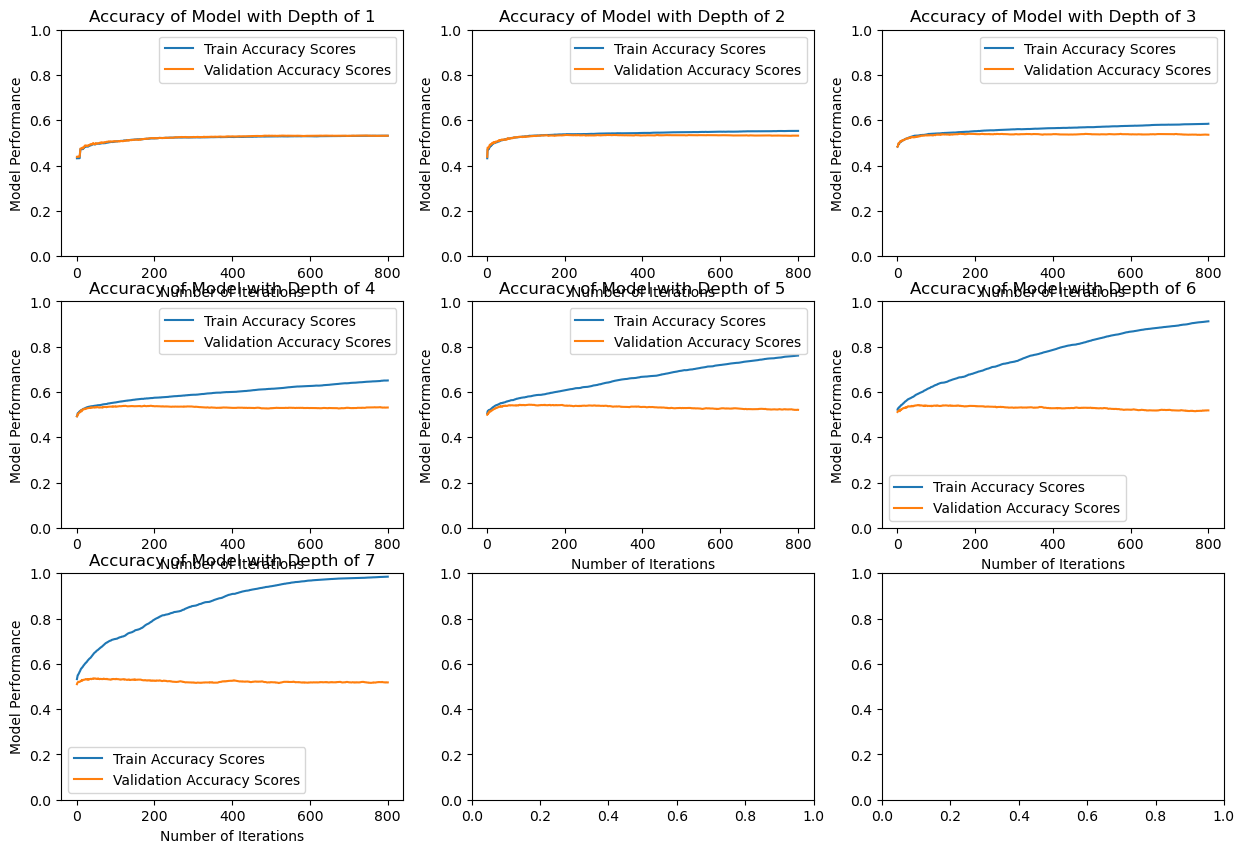

In [95]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15, 10))
axes = axes.ravel()
iterations = np.linspace(1, 800, 800)


for i in range(7):
    DTC = DecisionTreeClassifier(max_depth=i+1)

    ABC = AdaBoostClassifier(base_estimator = DTC, n_estimators = 800, learning_rate = 0.05, algorithm='SAMME.R')
    ada_model = ABC.fit(X_train.values, y_train_cat)

    ada_train_cur = list(ada_model.staged_score(X_train.values, y_train_cat))
    ada_val_cur = list(ada_model.staged_score(X_test.values, y_test_cat))

    print('depth:', i+1, 'max validation value:', max(ada_val_cur), 'n_estimators val:', ada_val_cur.index(max(ada_val_cur))+1)
    
    axes[i].plot(iterations, ada_train_cur, label = 'Train Accuracy Scores')
    axes[i].plot(iterations, ada_val_cur, label = 'Validation Accuracy Scores')
    axes[i].set_xlabel('Number of Iterations')
    axes[i].set_ylabel('Model Performance')
    axes[i].set_ylim([0, 1])
    axes[i].legend()

axes[0].title.set_text('Accuracy of Model with Depth of 1')
axes[1].title.set_text('Accuracy of Model with Depth of 2')
axes[2].title.set_text('Accuracy of Model with Depth of 3')
axes[3].title.set_text('Accuracy of Model with Depth of 4')
axes[4].title.set_text('Accuracy of Model with Depth of 5')
axes[5].title.set_text('Accuracy of Model with Depth of 6')
axes[6].title.set_text('Accuracy of Model with Depth of 7')

In [98]:
best_depth = 5

DTC = DecisionTreeClassifier(max_depth=best_depth)

ABC = AdaBoostClassifier(base_estimator = DTC, n_estimators = 189, learning_rate = 0.05, algorithm='SAMME.R', )
ada_model46 = ABC.fit(X_train, y_train_cat)


ada_train_acc = ada_model46.score(X_train, y_train_cat)
ada_test_acc = ada_model46.score(X_test, y_test_cat)

print(f"3 Equal Bins by Size Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"3 Equal Bins by Size Ada Boost Test Accuracy: {ada_test_acc:.2%}")\

ada_boost_count_test_score = ada_test_acc

3 Equal Bins by Size Ada Boost Train Accuracy: 60.42%
3 Equal Bins by Size Ada Boost Test Accuracy: 54.34%


## Model Summary Dataframe 

In [105]:
dictionary1 = {'model': 'linear regression', 'r^2': lreg_r2_test_val, 'MSE': lreg_mse_test, 'Accuracy': 'N/A'}
dictionary2 = {'model': 'RFE', 'r^2': rfe_test_r2, 'test MSE': rfe_test_mse, 'Accuracy': 'N/A'}
dictionary3 = {'model': 'Lasso Regularization', 'r^2': lasso_test_r2, 'MSE': lasso_test_mse, 'Accuracy': 'N/A'}
dictionary4 = {'model': 'KNN Classifier', 'r^2': 'N/A', 'MSE': 'N/A', 'Accuracy': knn_accuracy}
dictionary5 = {'model': 'Decision Tree Regressor dt2', 'r^2': dec_tree_r2_dt2, 'MSE': decision_tree_test_mse_dt2, 'Accuracy': 'N/A'}
dictionary6 = {'model': 'Decision Tree Regressor dt10', 'r^2': dec_tree_r2_dt10, 'MSE': decision_tree_test_mse_dt10, 'Accuracy': 'N/A'}

dictionary7 = {'model': 'Decision Tree Classifier dt2', 'r^2': 'N/A', 'MSE': lreg_mse_test, 'Accuracy': dt2_test_acc}
dictionary8 = {'model': 'Decision Tree Classifier dt10', 'r^2': 'N/A', 'MSE': lreg_mse_test, 'Accuracy': dt10_test_acc}
dictionary9 = {'model': 'Random Forest Regressor', 'r^2': random_forest_regressor_test, 'MSE': 'N/A', 'Accuracy': 'N/A'}
dictionary10 = {'model': 'Random Forest Classifier', 'r^2': 'N/A', 'MSE': 'N/A', 'Accuracy': random_forest_classifier_test}
dictionary11 = {'model': 'AdaBoost, equal range bins', 'r^2': 'N/A', 'MSE': 'N/A', 'Accuracy': ada_boost_range_test_score}
dictionary12 = {'model': 'AdaBoost, equal count bins', 'r^2': 'N/A', 'MSE': 'N/A', 'Accuracy': ada_boost_count_test_score}

summary = []
summary.append(dictionary1)
summary.append(dictionary2)
summary.append(dictionary3)
summary.append(dictionary4)
summary.append(dictionary5)
summary.append(dictionary6)
summary.append(dictionary7)
summary.append(dictionary8)
summary.append(dictionary9)
summary.append(dictionary10)
summary.append(dictionary11)
summary.append(dictionary12)

results = pd.DataFrame.from_records(summary)
results

model       r^2         MSE  Accuracy    test MSE
0               linear regression   0.21451  420.480166       N/A         NaN
1                             RFE  0.211763         NaN       N/A  421.950784
2            Lasso Regularization  0.178162  439.937606       N/A         NaN
3                  KNN Classifier       N/A         N/A  0.547173         NaN
4     Decision Tree Regressor dt2  0.118046  472.117882       N/A         NaN
5    Decision Tree Regressor dt10  0.182236  437.756523       N/A         NaN
6    Decision Tree Classifier dt2       N/A  420.480166  0.438701         NaN
7   Decision Tree Classifier dt10       N/A  420.480166  0.509365         NaN
8         Random Forest Regressor  0.314852         N/A       N/A         NaN
9        Random Forest Classifier       N/A         N/A   0.55692         NaN
10     AdaBoost, equal range bins       N/A         N/A  0.518244         NaN
11     AdaBoost, equal count bins       N/A         N/A   0.54342         NaN